Cryptography

### Team
<ol>
    <li> Mark Pearson </li>
    <li> Ronan Geraghty</li>
    <li> Milan Patel </li>
    <li> Will Steynor </li>
</ol>



In [1]:
from NumberFunctions import *
import numpy as np
import random as ran
import matplotlib.pyplot as plt
from time import process_time
import pandas as pd
import numba
import time
import secrets
import os

Stuff extra to include

+ difference between asymmetric and symmetric cryptography

+ Steganography

+ wrighting own pow function with acceleration Done

# Introduction

### Style Guide - PEP 8

Our group will be using the coding style PEP 8 in this project. A PEP stands for 'Python Enhancement Proposal' which is a python document proving information for the Python community. For example, PEP 1 is called 'PEP Purpose and Guidelines'.

We will be using PEP 8 as it will make our code easier to read. Additionally, the project is being developed by different people so having a consistent coding style will make the code feel more seamless and polished.

The guidelines for Pep 8 are at https://www.python.org/dev/peps/pep-0008/

### Big Integers

In this project we want to use numba which will allow us to compile python code. However, one problem we will have with using this is an overflow error with dealing with big integers. A natural example of this would be a hand tally counter, when all the rotors become 9 then the addition of an extra click will make to system go to all zeros. Therefore, the system can count but has to be modulo $10^{\text{number of rotors}}$. An example to do with computers would be,

Assume we have a n-bit machine, we have a max size $2^n -1$. If we do
> $(2^n -1) + (2^n-1) = 2 \cdot 2^n - 2 \geq 2^n -1$

The result will be out of range. The program will either raise an error or carry on the process but only with the last n bits (taking the last n bits is essentially doing $\pmod{2^{n+1}}$). Additionally, if the input to a function is set as 'int64' then the function is limited to working with 64 bit integers. Therefore, for the numba algorithms they can only be used with bits smaller than the bit size of the CPU. Also when there is a square in the algorithm the input has to be a bit number half the bit size of the CPU.



This problem can be solved by creating a type class named something like 'BigInt' for numba. However, the solution created may end up being slower than the normal python implementation. 

By looking at the python source code on github https://github.com/python/cpython/blob/master/Objects/longobject.c, (which is not written in python) we gain an understanding on how python stores and processes integers bigger than the bit size of the CPU.

In Python $3.x$ the types 'long' and 'int' were merged together. Therefore, the integers are non limited in length. These integers are stored in base $2^{30}$, with the number being stored in a int32 array. Below is an example:

> \begin{align*}
& 64563604292343170255\\
=& 1231 \cdot (2^{30})^{0} + 32 \cdot (2^{30})^1 + 56 \cdot (2^{30})^2
\end{align*}

Therefore, this will be stored as $[1231, 32, 56]$
Since the range for each element is $[0,2^{30}-1]$ two bits are left because these are required for some operations. An example of an operation is when adding, as sometimes the addition will overflow the base $2^{30}$, when this happens it carries over to the next element.

Another interesting method is how python multiplies two large integers together, it doesn't use repeated adding which multiplication is defined as but instead it uses an algorithm called 'Karatsuba Algorithm'.



### The Square and Multiply Algorithm

In this project we want to use numba which will allow us to compile python code. This is because in cryptography many functions take a long time to run. However, the numba module does not support the 'pow' function. Therefore, we will make our own 'pow' function that will be based on Square and Multiply Algorithm. This uses the fact

>$$
[a^b \mod{N}]=
\begin{cases}
[(a^{b/2})^2 \mod{N}], &\textrm{when $b$ is even}\\
[a\cdot (a^{(b-1)/2})^2 \mod{N}], &\textrm{when $b$ is odd}
\end{cases}
$$

In [2]:
@numba.jit(numba.uint64(numba.uint64, numba.uint64, numba.uint64), nopython=True)
def my_pow(a, b, N):
    r"""Square and Multiply

    Calculates a^b mod(N), in time polynomial in |a|,|b| and |N|

    Parameters
    ----------
    a : int, up to 63 bit
    b : int, up to 63 bit
        b > 0
    N : int, up to 31 bit

    Returns
    -------
    int
        The solution to a^b mod(N)   
    """
    x = a
    t = 1
    # So solution is tx^b mod(N)
    while b > 0:
        if b % 2 == 1:
            # Odd
            t, b = (t*x) % N, b-1
        x, b = ((x % N)**2) % N, b//2
    return t

In [3]:
# Tests
assert my_pow(12321, 546547, 2349809) == pow(12321, 546547, 2349809)
assert my_pow(4564, 47, 9809) == pow(4564, 47, 9809)
assert my_pow(2**33, 2**33, 21312) == pow(2**33, 2**33, 21312)

n = 63
assert my_pow(2**n, 2**n, 8589934591) == pow(2**n, 2**n, 8589934591)

In [4]:
%timeit my_pow(12321, 546547, 2349809)
%timeit pow(12321, 546547, 2349809)

1.4 µs ± 42.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
2.37 µs ± 64.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Therefore, the code which was just created is over $1.5$x faster than the python built in function.

However, this function has its limits as the parameters have to be 64 bit integers and in a calculation if a number becomes larger than 64 bits then an overflow error occurs, meaning the first few bits will be dropped leading to the incorrect result.

### Create File Structure

We will need a file structure, this will be used to make the files neater and easier to read. For example, it will be used to store running times for some algorithms. As running these at run time will make the project take a long time to run. 

In [4]:
directory = 'data'

if not os.path.exists(directory):
    os.makedirs(directory)

Is Will in this team or should we sub him out.

## Core 1: Ciphers, Encryption, Decryption and Cracking

### The Caesar Cipher

Firstly before getting into different types of ciphers and how to crack these ciphers, we will define a cipher.

A cipher is simply an algorithm used to encrypt data, and since we use an algorithm, we can reverse this algorithm to decrypt already encrypted data given that we have enough information.

These algorithms used for encryption can be very simple, in fact the first cipher we look at, The Caesar Cipher, was used by the Roman leader Julian Caeser to encrypt messages. The Caesar Cipher is a type of cipher known as a substitution cipher, this means that each letter (this can include symbols, numbers and pretty much any character you want) is replaced by another letter. The Caesar Cipher does this by first choosing a key which can be a number from 1 to 26 (this can be a larger range as you add more characters as you'll see) let's say we choose the key 12. Now you align the number 12, which has the letter L associated with it, with the letter A and shift everything else along with it as shown below.

     A | B | C | D | E | F | G | H | I | J  | K  | L  | M  | N  | O  | P  | Q  | R  | S  | T  | U  | V  | W  | X  | Y  | Z
     1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26  
    ---|---|---|---|---|---|---|---|---|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----
     A | B | C | D | E | F | G | H | I | J  | K  | L  | M  | N  | O  | P  | Q  | R  | S  | T  | U  | V  | W  | X  | Y  | Z
     
                                                           |
                                                           |
                                                           V
                                                           
    L  | M  | N  | O  | P  | Q  | R  | S  | T  | U  | V  | W  | X  | Y  | Z  | A | B | C | D | E | F | G | H | I | J  | K  | 
    12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 
    ---|----|----|----|----|----|----|----|----|----|----|----|----|----|----|---|---|---|---|---|---|---|---|---|----|----|
     A | B  | C  | D  | E  | F  | G  | H  | I  | J  | K  | L  | M  | N  | O  | P | Q | R | S | T | U | V | W | X | Y  | Z  |
     
So now using our key table above we can encrypt a message, for example "The Caeser Cipher" will become "Esp Nlpdlc Ntaspc" when encrypted using key 12 as above. Now that you understand how the cipher works and what a cipher is, we will program a function that implements the Caesar Cipher for us.
     
     
     
 

In [1]:


def Caesar_cipher_basic(message,key,setting): 
    '''This function will take in a message you wish to encrypt or decrypt,
    using the Caesar Cipher and the key you wish to use to encrypt or decrypt the
    message with'''
    Alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    if key>len(Alphabet) or key<0: #Here we make sure that the key entered is a valid key
        return("Please enter a valid key")
    if not (setting == "encrypt" or setting == "decrypt"):
        return("Please enter a valid setting")
    empty = ''
    MES = message.upper() #Since we are using only capital letters, we must capitalize the whole message
    for x in MES:
        if x in Alphabet:      
            index = Alphabet.find(x)
            if setting == "encrypt":
                index = index + key
            else:
                index = index - key #When the setting is decrypt we do the algorithm in reverse to recieve the original message
            index = index%len(Alphabet)
            empty = empty + Alphabet[index]
        else:
            empty = empty + x
    return(empty)

Caesar_cipher_basic("The Caesar Cipher", 11, "encrypt") #Check this is the same as above however key is 11 as index = position-1


'ESP NLPDLC NTASPC'

### Extending The Caesar Cipher

As mentioned above we do not have to limit ourselves to only substituting capitalized letters as we have above, this was used for simplicity before computer algorithms could quickly encrypt messages. Now we have the ability to encrypt thousands of different characters extremely quickly, however we will still limit ourselves a bit. Below we will use a larger set of characters to choose from by using the ASCII characters in the range 32 to 126. The reason we will use this range is because it involves most punctuation used in the English language, all the numbers and both capitalized and uncapitalized letters.

In [2]:
def Character_Set(n,m):
    '''Returns the character set with which you wish to encrypt the message using'''
    Characters = ''
    for i in range(n,m+1):
        c = chr(i)
        Characters += c
    return Characters

encounter = Character_Set(32,126) #Our character set to be used
        
def Caesar_cipher_ext(mes,k,s):
    '''This is the same function as "Caeser_cipher_basic", however it now uses the character set
    encounter which is defined outside of the function to encrypt and decrypt our messages with'''
    if k>len(encounter) or k<0:
        return("Please enter a valid key")
    if not (s == "encrypt" or s == "decrypt"):
        return("Please enter a valid setting")
    empty = ''
    for x in mes:
        if x in encounter:      
            index = encounter.find(x)
            if s == "encrypt":
                index = index + k
            else:
                index = index - k
            index = index%len(encounter)
            empty = empty + encounter[index]
        else:
            empty = empty + x
    return(empty)
Caesar_cipher_ext("The Caesar Cipher", 11, "encrypt")#Notice this looks different to above with the same key

'_sp+Nlp~l}+Nt{sp}'

### Cracking The Caesar Cipher

Although The Caesar Cipher would of been useful before the age of computers, today it is very rare in usage other than for introductions to Ciphers. The reason for this is because it is simply too easy for a computer to "Brute-force attack" the cipher. A Bruter-force attack is simple, it is an algorithm which attempts every possible key for a message and outputs the decryption of that message. In more advandced ciphers this is not a feasible method for cracking an encrypted message. However since the Caesar Cipher has a very small amount of possible keys, in our case only 95, it takes very little time to attempt every key. 

Now reading through every decrypted message to check if it is the original may still take a while, so we can check some properties the original message might display. For example if we know the most commonly used letter in the english language and the most commonly used word, we could quickly check if the decrypted message contains this word or has the same most common letter.

Using data from http://en.wikipedia.org/wiki/Letter_frequency, which we will use again later, we see that "e" is the most common letter, making up about 12.702% of all used letters. Also using data from https://en.wikipedia.org/wiki/Most_common_words_in_English, we see that "the" is the most common word in the english language. From this we can check if the most common letter in our decrypted message is "e", or if the word "the" is contained within our decrypted message. If it is then we could highlight this message, which will allow us to see messages which our more likely to be the true message, and save us time. This is a technique we will go more in depth with later, this is just basic implementation of this data.


In [4]:
def common_letter (message):
    '''Returns the most common letter in a message'''
    message = message.lower() #We only check for lower case letters here
    #The code below counts how many times a letter occurs in the message and returns the letter with the most counts
    return(max(((y, message.count(y)) for y in message), key=lambda x:x[1])[0]) #This counts how many times a letter occurs 
    

def Caesar_cipher_brute(message):
    '''This fucntion does a Brute-force attack on the message by attempting
    every possible key and outputting the decrypted message for a given key'''
    totalkeys = len(encounter)
    for k in range(0,totalkeys): #We want to use every possible key 
        translation = Caesar_cipher_ext(message,k,"decrypt")
        if common_letter(translation) == "e"  or ("the" in translation.lower()) == True: #Checking for our potential indicators
            print("*Key", k, "is more likely to be the true key, message - ", translation)
        else:
            print("Key", k,"message -", translation)
            
Caesar_cipher_brute('_sp+Nlp~l}+Nt{sp}')

Key 0 message - _sp+Nlp~l}+Nt{sp}
Key 1 message - ^ro*Mko}k|*Mszro|
Key 2 message - ]qn)Ljn|j{)Lryqn{
Key 3 message - \pm(Kim{iz(Kqxpmz
Key 4 message - [ol'Jhlzhy'Jpwoly
Key 5 message - Znk&Igkygx&Iovnkx
Key 6 message - Ymj%Hfjxfw%Hnumjw
Key 7 message - Xli$Geiwev$Gmtliv
Key 8 message - Wkh#Fdhvdu#Flskhu
Key 9 message - Vjg"Ecguct"Ekrjgt
Key 10 message - Uif!Dbftbs!Djqifs
*Key 11 is more likely to be the true key, message -  The Caesar Cipher
Key 12 message - Sgd~B`dr`q~Bhogdq
Key 13 message - Rfc}A_cq_p}Agnfcp
Key 14 message - Qeb|@^bp^o|@fmebo
Key 15 message - Pda{?]ao]n{?eldan
Key 16 message - Oc`z>\`n\mz>dkc`m
Key 17 message - Nb_y=[_m[ly=cjb_l
Key 18 message - Ma^x<Z^lZkx<bia^k
Key 19 message - L`]w;Y]kYjw;ah`]j
Key 20 message - K_\v:X\jXiv:`g_\i
Key 21 message - J^[u9W[iWhu9_f^[h
Key 22 message - I]Zt8VZhVgt8^e]Zg
Key 23 message - H\Ys7UYgUfs7]d\Yf
Key 24 message - G[Xr6TXfTer6\c[Xe
Key 25 message - FZWq5SWeSdq5[bZWd
Key 26 message - EYVp4RVdRcp4ZaYVc
Key 27 message - DXUo3QUcQbo

### The Vigenère Cipher

Now we will look at another substitution cipher called the Vigenère Cipher. In fact the Vigenère Cipher is a polyalphabetic cipher, which means it uses multiple keys to encrypt the data at different points of the data. The Vigenère Cipher is very similar to the Caesar Cipher, in fact it is just the Caesar Cipher applied to data multiple times with different keys at each point cycling through the same subkeys given by the key of the Vigenère Cipher. To clear this up it is easy to first follow an example. 

First we need a message we wish to encrypt using the Vigenère Cipher, we will use the message "ENCRYPT THIS MESSAGE". Now we need a key which we will use to encrypt this message, however unlike the Caesar Cipher, the Vigenère Cipher uses a collection of letters (or later we will see any character) to encrypt the message. For our example we will use the key "SECRET". Now each letter of our key "SECRET" is a subkey and we will cycle through these keys and apply the Caeser Cipher at each point in our message using the current subkey. Hence the first letter in our message is "E", and the first letter in our key is "S", so the letter "E" will be encrypted using the Caeser Cipher and the key "S". However of course "S" is not a number as our keys were when we previously used the Caesar Cipher, however again if you look at the table we used when discussing the Caesar Cipher, you can see the letter S has the number 19 associated with it, so this is the key we use. Thus the subkey used at each letter of the message is show below.     
 
 
    Vigenère key  | S  | E  | C  | R  | E  | T  | S  |    | E  | C  | R  | E  |    | T  | S  | E  | C  | R  | E  | T  |
    Caesar subkey | 19 | 5  | 3  | 18 | 5  | 20 | 19 |    | 5  | 3  | 18 | 5  |    | 20 | 19 | 5  | 3  | 18 | 5  | 20 |
                  |----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|       
    Message       | E  | N  | C  | R  | Y  | P  | T  |    | T  | H  | I  | S  |    | M  | E  | S  | S  | A  | G  | E  |
 
 
However again as happened with the Caesar Cipher we can see that spaces must be ignored for now and all other characters but capital letters, again two versions of the Vigenère Cipher will be given, one basic and one which can use as many characters as you want (In ASCII). 

Now Although the Vigenère Cipher is similar to the Caeser Cipher, it is orders of magnitude more secure. For example with the character set above "Alphabet", the Caesar Cipher has only 26 keys to attempt, however the Vigenère Cipher has $26^{n}$ possible keys where $n$ is the length of the key. Thus the longer the key you use the more secure your encrypted message is, this is why we can not use the "Brute-force Attack" against a message encrypted with Vigenère Cipher (Technically we can however this will become very unfeisable as the length of the key increases).

In [5]:
def Vigenere_cipher_basic(message, key, setting):
    '''This function will use the Vigenère Cipher to encrypt or 
    decrypt a message for a given key, provided the characters
    in the key are letters'''
    Alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    if not (setting == "encrypt" or setting == "decrypt"):
        return("Please enter a valid setting")
    key = key.upper() #If the user inputs a non-capitalized key, we must capitalize it for the cipher to work
    output = ""
    pos = 0 #This keeps track of the cycling of the key, telling us which subkey to use and where
    repeat = len(key)#If the index of the subkey is larger than the length of the key we repeat and use the first subkey again
    for x in message:
        if x.upper() in Alphabet:#If the message is not capitalized, we capitalize the letters so we can encrypt them
            index = Alphabet.find(x.upper())
            if setting == "encrypt":
                index += Alphabet.find(key[pos])
            else:
                index -= Alphabet.find(key[pos])
            index = index%len(Alphabet)
            if x.isupper():#If the current letter was originally capitalized, the encrypted chracter will also be capitalized
                output = output + Alphabet[index]
            if x.islower():#If the current letter was originally not capitalized, the encrypted chracter will also not be
                output = output + Alphabet[index].lower()
            pos += 1
            if pos == repeat:
                pos = 0
        else:
            output += x
    return(output)


Vigenere_cipher_basic("Encrypt this message", "secret","encrypt")

'Wreicil xjzw fwwurkx'

### Extending The Vigenère Cipher

Here we do just as we did when extending the character set of the Caesar Cipher, so again we will use the character set we called "encounter" which is the ASCII chracters in the range 32 to 126. Although this did make the Caeser Cipher harder to crack because we had to attempt 95 keys now, this is very little added computation time for a computer, however for the Vigenère Cipher ther are now $95^{n}$ keys to be attempted where $n$ is the length of the key being used. This means as the key length increases, the amount of possible keys increases massively, making the "Brute-force Attack" even less feisable.

In [5]:
import pyperclip as pp
def Vigenere_cipher_ext(message, key, setting):
    '''This is the same as the function Vigenere_ciper_basic, however we
    now use the character set encounter, also this means we no longer
    have any need to capitalize the key nor capitalize the message'''
    if not (setting == "encrypt" or setting == "decrypt"):
        return("Please enter a valid setting")
    output = ""
    pos = 0
    repeat = len(key)
    for x in message:
        if x in encounter:
            index = encounter.find(x)
            if setting == "encrypt":
                index += encounter.find(key[pos])
            else:
                index -= encounter.find(key[pos])
            index = index%len(encounter)
            output = output + encounter[index]
            pos += 1
            if pos == repeat:
                pos = 0
        else:
            output = output + x
    if setting == "encrypt":
        pp.copy(output)#This copies the outputted message, so you can easily send the encrypted message to who you want
        print("Encrypted message has been copied")
    return(output)



### Cracking The Vigenère Cipher Using The Dictionary
Here we will begin looking at how to crack the Vigenère Cipher, as mentioned before this is more difficult to do than on a message encrypted using the Caeser Cipher as we can not simple brute-force attack the message. The problem is that if the person encrypting the message is using only the alphabet as their character set to encrypt their message, we do not know how long the key is they are using. If we were to assume the key was of length somewhere in the range [1,12] we have many keys to test, in fact we have.

>$\sum_{i=1}^{12} 26^{i} = 99246114928149461$ 

Which is a lot more than the 26 we had for the Caesar Cipher. On top of this taking the computer a very long time, we still have no rubust criteria that we can check a decrypted message against to see if it could be the original message, and it would take an extremly long time to check all 99246114928149462 decrypted messages. To add to the seemingly impossible task of cracking this cipher, we do not know how long the key actually is, so for all we know the key may be of length 10, 100, 1000 or anything.

Thus when trying to crack the Vigenère Cipher, we must go about this using a more efficent and robust method. One method we will use is called a "Dictionary attack", many hackers will use this method to attempt many passwords to gain access to someones account. This method depends on one key idea, that humans tend to use words for passwords or in this case for the key because words are easier to remember, however because of these dictionary attacks, this can leave your account or encryption vulnerable. The basis of these dictionary attacks is to simply attempt a very large set of words as the key to try and decrypt a message. This is very simple, as to do this we can download a text file filled with english words (The text file I will be using can be found here http://www.gwicks.net/dictionaries.htm). Now all we have to do is attempt every word on this file, which on the file we will be using is 65,000 words. Though this may seem like many words you must keep in mind that even if we knew that the key was of length 4, using a brute-force attack we would still need to attempt,

>$26^{4} = 4569764$ keys.

However as I mentioned, there is one more problem we must over come, we can not manually check all 65,000 decrypted messages ourself as this will take a long time. To get around this we come up with a more robust method for checking if a message is likely the original than before. 

First we need a function which splits up each word (collectios of characters with a space inbetween them) in the decrypted message for a given key, and puts each individual word into a potential word list. Then for each element in the list, we want to check if this element is the same as any word in our dictionary text file which indicates that this element is a word. Thus we count how many words this message contains and then divide this by how many elements are in the potential word list, to get the percentage of words in this decrypted message are in the dictionary.

Next we need a function that checks if the percentage of real words (words in the dictionary) and percentage of letters to characters in a message is above a certain threshold. If the message is above our threshold percentage, than we say there is a chance this is the original message. Hence by combining these two functions we have a more robust procedure to make sure only decrypted messages which are very likely to be the original are shown, which in effect means we only have to read a handful of wrong messages.

In [6]:
alphabet = "'ABCDEFGHIJKLMNOPQRSTUVWXYZ'"
import pyperclip as pp
def wordspercent(message):
    '''This is the first function we wanted above, this function returns
    the percentage of words a message has that are in our text file
    dictionary.'''
    message = message.lower()#Use lower case to match the way the words are written in our text file
    potential = message.split()#Split collections of letters up if a space is between them and make a list of these collections
    if potential == []:
        return 0
    matches = 0#This will keep track of how many words the message has that is in our dictionary
    dictionary = open('Dictionary_words.txt') #Read the text file that contains our dictionary words
    Words = {}#Create a dictionary of all of our words in the text file
    for x in dictionary.read().split('\n'):
        Words[x] = None
        dictionary.close()

    for y in potential:
        if y in Words:
            matches += 1 #If the element in our potential list is the same as a word in our dictionary we add 1 to matches
    return matches / len(potential)#Ration of words to non words

def potentialofmessage(message, wpercent, lpercent):
    '''For a given minimum percentage of words and letters, this function
    returns if the inputted message equals or exceeds this percentage 
    for both word percentage and letter percentage'''
    wMatch = wordspercent(message) * 100 >= wpercent #checks if the percentage of words for a message is above the minimum
    count = 0 #This will count the amount of characters in our message are in the alphabet
    for x in message:
        if x.upper() in alphabet:
            count += 1
    letsper = count / len(message) * 100 #Percentage of letters to non letters
    lMatch = letsper >= lpercent #Checking this percentage is above the minimum
    isword = wMatch and lMatch #If and only if both are True, will isword  be True also
    return isword

def Vigenere_cipher_crack(message):
    '''This is the main crack function, it takes in the encrypted messaged
    and returns decrypted messages and their keys that could potentially by the 
    original message and key, it does this by using the functions we created above'''
    words = open("Dictionary_words.txt")
    check = words.readlines() #Check is the words we will check that could potentially be the key
    words.close()
    for x in check:
        x = x.strip()
        text = Vigenere_cipher_basic(message, x, "decrypt")#The reason for using the basic function here is because
        #only words can be the potential key meaning if the true key uses characters outside of the set "alphabet",
        #We can not crack it using this function.
        if potentialofmessage(text, 50, 80): #If the decrypted message is likely the original we run the code below
            print('Possible message, Key ' + x + ' - ' + text)             
            user = input('If you want to end enter "Yes", else just press enter.')#The user will read the decrypted message
            #and if they believe this seems like the original message they can stop the functin here by typing "Yes".
            if user =="Yes":
                pp.copy(text)
                print("Encrypted message has been copied")
                return text
Vigenere_cipher_crack("Qvmnk uidt nidsbkp")

Possible message, Key abel - Quick test message
If you want to end enter "Yes", else just press enter.Yes
Encrypted message has been copied


'Quick test message'

### Cracking The Vigenère Cipher (Key Lengths)

Now clearly the method used above is not very efficent and has many limitations as checking 65,000 keys can still take a long time for the average computer, especially when the key used for encyption may not even be a word so will not be able to be decrypted using this method. Another problem is that if the word starts with a z for example "zurrich", the algorithm will try every word that comes before it alphabetically, rather than trying the most likely keys first. We now try to get past these limitations and crack the Vigenère Cipher for almost all cases as we will see, in doing this we will no longer use the basic Vigenère Cipher, instead we will use the extended version that uses any character set. The method we will be using is called "The Babbage Attack & Kasiski Examination".

The first step in this method is to identify any repeated sequences in the enrypted message. We only count sequences of letters of 3 or more, however in this code we will limit ourselves to sequences of any length from 3 to 6 to speed up the algorithm. The reason we do this is because many words such as "the", as I mentioned before, are used many times in a single message, or we can notice that most verbs have the same ending "ing". Now if we notice that the same sequence of letters repeat multiple times, this may indicate the same letters being encrypted using the same subkey as before due to the subkey repeating. For example, if we encrypt the sentance "You going running?", using our Vigenère Cipher with the key "examples", the output is "?hWmX\\ObMxTc_[ObM8". We notice that the sequence of letters "obM" repeats twice. This can be explained by following the example below.

    Vigenère key  | e  | x  | a  |  m | p  | l  | e  | s  | e  | x  | a  | m  | p  | l  | e  | s  | e  | x  |
                  |----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|     
    Message       | Y  | o  | u  |    | g  | o  | i  | n  | g  |    | r  | u  | n  | n  | i  | n  | g  | ?  | 


Notice how in our message we have the repeated sequence "ing" eppear twice, and both times this is being encrypted using the 
same subkeys, "e", "s" and "e" respectively. This is extremely useful when trying to find the key, as we can now count the number of characters between repeats of sequences. As you can see the number of characters between the repeated sequence "obM" in our encrypted message is 8, counting from the first letter of the first sequence, to the letter before the beggining of the second sequence. Here it just so happens that the number of characters between the repeats is the exact same as the legnth of the key, however this will not happen all the time. Though this is not always true it is true that if the same letters in the orginial message are being encoded by the same characters in the key, than one of the factors of the distance between these two sequences must be the true key length, due to the cyclic nature of the encryption. This brings us to the next step of our method.

Now we must find the factors of the distance between repeated sequences. To show how we do this we will look at a longer encrypted message given below:

>"'kGmj\[sMhK\XlXiTgK\XlRUZ^Tme\JU_8a7wcKsH^G\p_KUJbPUpNHc[madfefsjTaOpYUhekGQV[Z`_&a7wZehXrK\XlSme[GaelZcelVOcaef[gPW_Ts"

Now you can check for youself using the functions below, this encrypted message has four repeated sequences "K\\X", "\\XL", "A7W" and "K\\XL". Now the distances between these repeated sequences are 8, 48, 72 and 80. In this part of the method as I mentioned we get the factors of the distances between the sequences, however we only want the factors that occur most, as these are more likely to be the true key length. In this case the most likely key lengths would be 2, 4 and 8 as they are factors of all 4 distances. Our next step will be to get every second, fourth and eigth letter, however before doing this we will create functions to carry out our method thus far.

       



In [7]:
import operator as op
import itertools
chr

def sequences(message):
    """The function we use to output the sequences that repeat in 
    the encrypted message, with the distance between the repeats with the first 
    occurence of the sequence."""
    message = message.upper()
    seq = {}
    le = len(message)+1
    for x in range(3,7): #To speed up this process, we only check sequences of length 3 to 6
        for y in range(le - x): # We use this range to stop ourselves using an index too large for the message
            checks = message[y:y + x] #Potential sequences
            for z in range(x + y, le - x):
                if message[z:z + x] == checks: #Checking if our potential sequence is repeated anywhere
                    if checks not in seq:                    
                        seq[checks] = [z-y] #inserts the distance between repeated sequences found
                    else:   
                        seq[checks].append(z - y)

    return(seq)

def factorslimit(n,m):
    """This will get the factors of a number up to a maximum factor,
    we do this to speed up the cracking process as trying all key lengths
    can take extremly long times."""
    factors = []  
    for x in range(2, m+1): 
        if n%x == 0:
            factors.append(x)
    return factors


def seqfactors(seqfactors):
    """This is the function we use to get the frequency of factors
    for the distances between repeated sequences, it allows
    us to know which factors are the most common"""
    frequency = {} #This dictionary will keep track of the factors and how often they occur
    count = []
    for x in seqfactors: #x are the sequences which have been repeated
        for y in seqfactors[x]: #y are the factors of the distances between repeated sequences
            if y not in frequency:
                frequency[y] = 0
            frequency[y] += 1
    for z in frequency: #z is again the repeated sequences
            count.append((z, frequency[z])) #We now use count to output only factors and their relative frequencies
    count.sort(key=op.itemgetter(1), reverse=True) #Order them buy the most common factor
    return count


def keylengths(message,m):
    """This uses all of the functions above to intake a message and output
    the most likely lengths of the key"""
    sequence = sequences(message)
    factors = {}
    for x in sequence:
        factors[x] = []
        for y in sequence[x]:
            factors[x].extend(factorslimit(y,m))
    faccount = seqfactors(factors)
    potentiallength = []
    for z in faccount:
        potentiallength.append(z[0])
    return potentiallength[:5] #Output only the 5 most likely key lengths 

        





### Cracking The Vigenère Cipher (Letter Frequency Analysis)

Now we are on to the next step of "The Babbage Attack & Kasiski Examination". With the functions we created above, our next step is to now get every $N^{th}$ letter from the encrypted message where $N$ is our most likely key lengths. We will have to do this for all key lengths we think could potentially be correct, which we set to be limited to the 5 most likely above. This is very simple for us to do, we just look at our message and choose every $N^{th}$ character starting from the first character of the message. We then do this again starting from the second character of the message, and repeat this up to the $N-1$ character in the message. Again we repeat this for each potential key length. For example for the encrypted message we used before:

>"'kGmj\[sMhK\XlXiTgK\XlRUZ^Tme\JU_8a7wcKsH^G\p_KUJbPUpNHc[madfefsjTaOpYUhekGQV[Z`_&a7wZehXrK\XlSme[GaelZcelVOcaef[gPW_Ts"

If we believed the key was of length 4, than we would select every fourth character in the message as so:

 Every $4^{th}$ character from the first character:

>'jMXTXZe_wHpJp[fjpeV_wXXeeec[_

Every $4^{th}$ character from the second character:

>k\\hlgl^\\8c^_bNmeTYk[&Zrl[llagT

Every $4^{th}$ character from the third character:

>G[KXKRTJaKGKPHafaUGZaeKSGZVePs

Every $4^{th}$ character from the fourth character:

>ms\\i\\UmU7s\\UUcdsOhQ`7h\\macOfW

Now if we have predicted the length of the key correct, this means the the first character of the key encrypts every $4^{th}$ character from the first character of the message and then the second character of the key encrypts every $4^{th}$ character from the second character of the message and so on. This is important to us as now we can attempt every possible character for each character in the key which is only $95n$ subkeys to attempt for a key of length $n$. Our next step will be deciding which characters are most likely to be our subkey.

As I briefly mentioned above, language is not a uniform distribution of letters, some letters occur more frequently than others, and this data can again be found at http://en.wikipedia.org/wiki/Letter_frequency. The table below shows what percentage of the English language is made up of each letter to 1 d.p. 
    
         A | B | C | D | E  | F | G | H | I | J | K | L | M | N | O | P | Q | R | S | T | U | V | W | X | Y | Z
        ---|---|---|---|----|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---  
        8.2|1.3|2.8|4.3|12.7|2.2|2.0|6.1|7.0|0.2|0.8|4.0|2.4|6.8|7.5|1.9|0.1|6.0|6.3|9.1|2.8|1.0|2.4|0.2|2.0|0.1
        
This is clearly a useful fact when trying to decrypt messages. Now for this step we want to try all possible subkeys to try and decrypt each of our sequences of $N^{th}$ letters above. From this we want to analyse the frequency of letters that occur in each decrypted message and see how well this message matches the data above. We do this by checking if the 6 most frequent letters in our decrypted message and the 6 least frequent letters match the data . From the data we see the 6 most frequent letters are "ETAOIN" and the 6 least frequent are "VKJXQZ". Thus we score each decrypted message on how many of their 6 most frequent and least frequent letters match the true 6 most frequent and least frequent. The subkeys that cause the decrypted message to have the highest score are than the most likely subkey used on these letters, which means we have found candiates for what is most likely the $n^{th}$ letter in the true key where $n$ is what character we start from when choosing every $N^{th}$ letter. 

Once we have done this, we can begin attempting each combination of most likely key lengths and most likely letters for each character in the key. First however we must create functions to do what we have described above.

In [8]:
# Data from http://en.wikipedia.org/wiki/Letter_frequency rounded to 2 decimal places
englishLetterFreq = {'A': 8.17, 'B': 1.29, 'C':2.78,'D': 4.25,  'E': 12.70,'F': 2.23,'G': 2.02, 'H': 6.09,'I':6.97,'J': 0.15,
'K': 0.77,'L': 4.03,'M': 2.41,'N': 6.75,'O': 7.51,'P':1.93,'Q': 0.10, 'R': 5.99, 'S': 6.33,'T': 9.06,  'U': 2.76, 
'V': 0.98,'W': 2.36, 'X': 0.15,'Y': 1.97,  'Z':0.07} 

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
frequency_alphabet = 'ETAOINSHRDLCUMWFGYPBVKJXQZ'

def factorsequences(length, initial, message):
    """This function will create a sequence of every nth letter for
    an inputted message starting from different positions"""
    message = message.upper()
    string = ''
    while initial < len(message)+1: #To stop using too large of an index
        string += message[initial-1]
        initial += length #Adding the distance of what we believe is the key length to get every nth letter
    return string #Sequence we want of every nth letter

def letters(message):
    """This will get how many times a given letter occurs
    in the inputted message"""
    Count = {}
    for i in alphabet:
        Count[i]= 0
    for x in message.upper():#Must capitalize the message so it matches the format of "alphabet"
        if x in alphabet:
            Count[x] += 1
    return(Count)



def frequency(message):
    """This function will output a message of all letters in the alphabet ordered
    by their frequency within the inputted message """
    count = letters(message) #Count how many of each letter occurs
    freq = {}
    for x in alphabet:
        if count[x] not in freq: #This checks if the frequency of letter x is already appended to dictionary "freq"
            freq[count[x]] = [x] # if no then we add the frequency to dictionary with the given letter
        else:
            freq[count[x]].append(x)#If yes then we just append it, so if two letters have the same frequency they are grouped.
    for y in freq:
        freq[y].sort(key=frequency_alphabet.find, reverse=True)#Put this in reverse order with respect to "frequency_alphabet"
        freq[y] = '' .join(freq[y]) #we put this into a string itself, so we keep track of what letters occured how many times
    freqfin = list(freq.items())#Turn our dictionary to a list
    freqfin.sort(key = op.itemgetter(0), reverse=True)#Order this list with respect to how ofter letters occur
    order = ""
    for z in freqfin:
        order = order + z[1] #Order will be the letters order with respect to how often each letter occurs
    return(order)


def Frequencymatch(message):
    """This function keeps track of the "score" of a decrypted message,
    which means how many of the 6 most and least frequent letters in the message
    match the true 6 most and least frequent letters in the Englsh language"""
    Order = frequency(message)
    matchScore = 0
    for x in "ETAOIN": 
        if x in Order[:6]: #Checks if one of the letters in "ETAOIN" are in the messages 6 most frequent letters
            matchScore += 1
    for y in "VKJXQZ":
        if y in Order[-6:]:#Checks if one of the letters in "VKJXQZ" are in the messages 6 least frequent letters
            matchScore += 1
    return matchScore



### Cracking The Vigenère Cipher 

Now that we have all of the preliminary functions, we can move on to the final step of cracking the Vigenère Cipher. We have come full circle and ended up where we started when cracking the Caesar cipher, using a "Brute-force Attack" as our final step. 

From the functions above, we now have the ability to output likely key lengths and likely characters at each position in the key for a message encyrpted using the Vigenère Cipher. All that is left to do is attempt every likely key length along with every combition of likely characters. Though the entire purpose of using the Babbage Attack & Kasiski Examination was to avoid going about cracking the cipher using a Brute-force attack, this allows us to attempt orders of magnitude less possible combinations for keys. For example if we knew the key was of length 7, using just a Brute-force attack, we would need to attempt

>$95^{7} = 69833729609375$ keys

However using the Babbage Attack & Kasiski Examination, as we only use the 4 most likely characters (you can use as many characters as you like, however I have choosen 4 to keep the process fast) for each position, we have to attempt

>$4^{7} = 16384$ keys

Though this is already a huge improvement, it is a much larger improvement if you take into accont the fact that we will not know the length of the key. Now all that's left is to create the functions that will complete our process.


In [9]:

def quick_bruteattempts(message, length, show):
    """This function takes an encrypted message, with a length of key 
    we would like to attempt the hacks with, and then attempts every combination
    of key we have using only the 4 most likely characters in each position of the key.
    Also you have the option to see which keys are being attempted by setting show
    to True."""
    combinations = itertools.product(range(0,4),repeat=length) #This will Create a list of all combinations of numbers 
                                                               # 0 to 3 in which there must be "length" numbers choosen. 
                                                               #We will use this later to attempt all key combinations
    frequency = []
    for x in range (1,length+1): #Due to the way the function "factorsequences" is set up, we must increase the range by 1 
                                 #in order to avoid index out of range error
        strings = factorsequences(length, x, message)#Gets all sequnces of letters when choosing the Nth letter.
        Matches = []
        for y in encounter:
            possdecrypt = Vigenere_cipher_ext(strings, y, "decrypt") #We attempt to decrypt each Nth letter substring using
                                                                     #All possible characters to get the likely characters
                                                                     #Using our "Frequencymatch" function.
            freq = Frequencymatch(possdecrypt)
            Matches.append((y,freq))
        Matches.sort(key=op.itemgetter(1),reverse = True) #Sort this by largest frequencies first
        frequency.append(Matches[:4])#Gets the 4 letters which are most likely to be the subkey for that position.
    if show == True: #This is for if you want to see what characters will be attempted for each key postion
        for n in range(0,len(frequency)):
            print("Characters to be attempted for character", n+1, ":")
            for z in frequency[n]:
                print(z[0])
    for comb in combinations: #This is where we get every combination of possible keys for the given key length
        attemptkey = ''
        for index in range(0,length):
            attemptkey += frequency[index][comb[index]][0] #Here we get every possible key for our given key length 
                                                           #and most likely characters
        if show == True: #Just to show what key is being attempted
            print("Key being attempted", attemptkey)
        attempteddecrypt = Vigenere_cipher_ext(message, attemptkey, "decrypt")
        if potentialofmessage(attempteddecrypt, 50, 75) == True: #We only show messages that are likely to be the original
            Final = attempteddecrypt
            print("The key used could potentially be", attemptkey)
            print("Message using this key is - ", Final[:321],"...")#Only display first 321 characters of text
            user = input('If you want to end enter "Yes", else just press enter.') #If the user belives this is the message
                                                                                   #they can stop the process here
            if user =="Yes":
                pp.copy(Final)
                print("Encrypted message has been copied")
                return Final #Decrypted message outputed

def Vigenere_crack(message,m, show):    
    """This is our final function that cracks an inputted encyrpted message, it is essentially
    a neater verison of our "qucik_bruteattempts" however it uses every possible
    key length, not just one"""
    potentiallengths = keylengths(message,m) # Get 5 most possible key lengths
    if show == True: #If the user wants to see what key lengths will be attempted
        display = ''
        for x in potentiallengths:
            display += '%s ' %(x)
        print("The most likely key lengths are", display)
        for y in potentiallengths:
            allcombos = 4**y #Just to show how many combinations must be attempted for a given key length
            if show == True:
                print("Key length currently being attempted", y, ", there are", allcombos, "possible keys to be attempted at this length.")
            decryptedmessages = quick_bruteattempts(message, y, show)
            if not decryptedmessages == None: #If we find no possible decrypted messages, we move on to the next part of code
                break
        if decryptedmessages == None:#We now resort to a full Brute-force Attack if the user wants to
            user = input('Unable to decrypt message using efficent algorithm, would you like to attempt all other key lengths? Type "Yes" if so, else just press enter.')
            if not user =="Yes":
                return
            else:
                print('Attempting all other key lengths')
                for z in (1,m+1):
                    if z not in potentiallengths: #Only attempt keys we havent yet attempted
                        if show == True:
                            allcombos = 4**z
                            print("Key length currently being attempted", z, ", there are", allcombos, "possible keys to be attempted at this length.")
                        decryptedmessages = quick_bruteattempts_ext(message, z, show)
                        if not decryptedmessages == None:
                            break
                        if decryptedmessages == None:
                            return ("Could not decrypt message")
        return decryptedmessages #Output decrypted message


### Cracking The Vigenère Cipher Final Notes

We have finally cracked the Vigenère Cipher for most cases of encryption using this cipher. However I feel it is noteworth to mention the fact that if the encrypter uses a key the same length of the message, the message is uncrackable without attempting every possible key length and combination. Thus this is not a full proof method to cracking the cipher, however it is very good compared to just randomly guessing keys.

### The Affine Cipher

Now we will look at our third and final cipher, the Affine Cipher. Again the Affine Cipher is another monoalphabetic substitution cipher, in fact the Affine Cipher incorporates two ciphers in one. The first cipher it uses we have already met, it is the Caesar Cipher however the other cipher we have yet to discuss, it is called the Multiplicative Cipher. Before we discuss the Affine Cipher, we must understand the Multiplicative Cipher.

The Multiplicative Cipher is very similar to the Caesar Cipher, in fact it is the same sort of substituion cipher as the Caesar Cipher. The only difference between the two is that in the Caesar Cipher we find the index of each character in a message and add the value of our key to the characters index to get a new index which we use to substitute our original character out for a new one, however in the Multplicative Cipher, rather than simply adding the key to the index we multiply it. Again like in the Caesar Cipher, this multiplying of the index must be done modulo the length of our character set as if we did not do this our new index may be out of the character sets range. Below we will look at the same example we used for the Caesar Cipher, and see how a key of 12 will affect the indexes if we were to use the alphabet as our character set for the Multiplicative Cipher:

     A | B | C | D | E | F | G | H | I | J | K  | L  | M  | N  | O  | P  | Q  | R  | S  | T  | U  | V  | W  | X  | Y  | Z
     0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25  
    ---|---|---|---|---|---|---|---|---|---|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----
     A | B | C | D | E | F | G | H | I | J | K  | L  | M  | N  | O  | P  | Q  | R  | S  | T  | U  | V  | W  | X  | Y  | Z

   
                                                           |
                                                           |
                                                           V
 
     A | M  | Y  | K  | W  | I | U  | G | S  | E | Q  | C | O  | A | M  | Y  | K  | W  | I | U  | G | S  | E | Q  | C | O
     0 | 12 | 24 | 10 | 22 | 8 | 20 | 6 | 18 | 4 | 16 | 2 | 14 | 0 | 12 | 24 | 10 | 22 | 8 | 20 | 6 | 18 | 4 | 16 | 2 | 14
    ---|----|----|----|----|---|----|---|----|---|----|---|----|---|----|----|----|----|---|----|---|----|---|----|---|----
     A | B  | C  | D  | E  | F | G  | H | I  | J | K  | L | M  | N | O  | P  | Q  | R  | S | T  | U | V  | W | X  | Y |  Z


To be clear the top row is the character set with each characters index being shown, and below is the character that gets mapped to the character above when encrypted. Now after applying the key 12, as you can see the multiplicative cipher changes the indexes, however they are not all unique, in fact because of modular arithmatic after the originial letter indexed 12 the each letter is indexed the same way as the first 12. This as you may guess, is a big issue as when trying to decrypt a message using the above key how do we know whever the letter "A" should when decrypted become "A" again or "N". It is impossible to know this, so to avoid this we must use a key that is coprime to the length of our character set this way no overlapping letters will occur.

Now that we know how the Multiplicative Cipher works, the Affine Cipher is easy to understand. When using the Affine Cipher we need two keys, one key which we use for the encrypting the message using the Multiplicative Cipher that we will call "Multkey" and another for the Caesar Cipher that we will call "Caesarkey". If we want to encrypt using the Affine Cipher we first apply the Multiplicative Cipher to the message (essentially we multiply the index of each character by the Multkey) and then we apply the Caesar Cipher to the new message (Just add Caesar key to the index of each character), again we do this all modulo the length of the character set. If instead we want to decrypt using the Affine Cipher, instead we subtract the Ceasarkey from the index of each character in the message, and then multiply each index by the modular inverse of the Multikey and do this all modulo the length of the character set too. We have spoken about modular inverses earlier, so we know that if we multiply our Multikey by it's modular inverse "m" we have:

> $Multikey \times m \equiv 1 mod(n)$

Where $n$ is the length of our character set. Thus to see why this decryption process works lets say our Multikey is $M$ and it's modular inverse is $m$, let $n$ be the length of our character set, $a$ our Caesar key and finally $i$ the index of a character in the message we wish to encrypt. When encrypting $i$ we will get a new index we will call $e$ and we calculate this as so:

> $e = (iM + a) mod(n)$

Now to see how we get the original index when decrypting see below:

> $i = (m \times (e - a))mod(n) = (m \times (iM))mod(n) = imod(n) = i$

Thus we should now understand how encryption and decryption works using the Affine Cipher, so now we will create the functions that implement the Affine Cipher.

In [22]:
###REMOVE THIS IS IN FINAL PROJECT AS THIS WILL HAVE TO COME AFTER CORE 2
from NumberFunctions import *
import random as ran

def modular_inverse(a,n):
    '''Solves ax = 1 mod(n) for x in {1,2,3,...,m-1}'''
    gcd, x, y = gcd_ext(a, n)
    if gcd == 1:
        return x%n
    else:
        return "gcd not = 1"
###
import sys

def Usefulkeys(Multikey, Caesarkey, setting):
    """This is a function we will use in the Affine Cipher function
    to check that the keys being used for the Cipher actually work when 
    encrypting the text or so the user is aware they are using a weak key."""
    if setting == 'encrypt': #This only matters if the setting is to encrypt
        if Multikey == 1 and Caesarkey == 0: #This means the message will not be encrypted as the ciphers will change nothing
            #We use sys.exit below because this allows us to use this function inside our Affine Cipher function to stop it.
            sys.exit('The key being used to encrypt using the multiplicative cipher is 1 and the Caesar ciphe key is 0, meaning this will not encrypt the message, please enter a new key')                   
    if Multikey <= 0: #If it is 0, everything will be the same letter, any less will cause negative numbers, so it won't work
        sys.exit('Multiplicative key must be larger than 0, please enter a new key.')
    if Caesarkey < 0 or Caesarkey > len(encounter) - 1: #This wil lcause the Caesar key to be out of range
        sys.exit('Caesar key is outside of the range of the charcter set for the Caesar cipher, please enter a new key.')
    if not gcd(Multikey, len(encounter)) == 1: #As mentioend in the notes we need this for the Cipehr to work.
        sys.exit('The multiplicative key is not coprime to the size of the current character set, please change either the character set or key')
    
    
def keygeneration():
    """This is a function you can use to create a Multikey and Caesar key for yourself
    that is quick and will work, also it outputs it as one Affine Cipher key"""
    while True:
        Multikey = ran.randint(2, len(encounter)) #These both check that the keys are within the corrct range
        Caesarkey = ran.randint(2, len(encounter))
        if gcd(Multikey, len(encounter)) == 1: #To check it works for our code
            pp.copy(Multikey * len(encounter) + Caesarkey)
            return ("Affine Cipher key -,", Multikey * len(encounter) + Caesarkey,"has been copied.")


def Affine_cipher(message, key, setting):
    """This is where we apply the Affine Cipher"""
    if str(key).isdigit() == True:   #To check if the key entered is one Affine key or two keys the Multi and Caesar key.
        Multikey = key // len(encounter) #If it is one key, we must use this to get the two keys as show, also
                                         #though this is not neccesary and we could require the user to input 2 seperate keys,
                                         # this will allows us to crack the Cipher as you will see next, so this code will be
                                         #explained in the enxt section.
        Caesarkey = key % len(encounter)
    else: #If not one key, we have been given 2 keys a Multikey and a Caesar key
        Multikey = key[0]
        Caesarkey = key[1]
    Usefulkeys(Multikey, Caesarkey, setting) #Checks our keys work as mentioned in the function
    output = ''
    for x in message:
        if x in encounter:
            index = encounter.find(x)
            if setting == "encrypt":
                output += encounter[(index * Multikey + Caesarkey) % len(encounter)] #As mentioned in the notes this is how 
                                                                                     #Affine encryption works
            if setting == "decrypt":
                output +=  encounter[(index - Caesarkey) * modular_inverse(Multikey,len(encounter)) % len(encounter)]
                #The code above is implementing the method we saw in the notes to decrypt an affine encrypted message.
        else:
            output += x #If x is not in our character set, add the original character x to the message anyway.
    return output
                                                   
Affine_cipher("""X}/$wt/Rpt#p"/rx wt";/t}r") $x}v/p}s/str") $x}v/#)|q~{#/x}&~{&ts/r~}&t"$x}v/$wt|/$~/}%|qt"#;/pssx}v/~"/#%q$"pr$x}v/$wt/zt);/p}s/$wt}/r~}&t"$x}v/$wt/}t\'/}%|qt"/qprz/$~/p/#)|q~{=""", [1,0], "encrypt")


SystemExit: The key being used to encrypt using the multiplicative cipher is 1 and the Caesar ciphe key is 0, meaning this will not encrypt the message, please enter a new key

### Cracking The Affine Cipher

The method for cracking the Affine Cipher is the same as the method we used for the Caesar Cipher, we use a "Brute-force Attack". The reason for this is because, there are a limited amount of keys you can use for the Affine Cipher, in fact if $n$ is the length of our character set, there are only $n^{2}$ possible keys. The reason being for this is simple, it is because we work modulo $n$ and we have a choice for the Multikey of which there are $n$ possible values it can take due to working modulo $n$ (actually a bit less since we wouldn't expect this to be a value of 1 or a value such that gcd(Multikey,$n$) is not equal to 1), and for the Caesarkey we also have $n$ possible keys. Thus the amount of combinations of keys we can have is equal to at most:

>$n \times n = n^{2}$

Now this is the reason for having the section of code in our Affine Cipher that let us input one key and in return we got both the Caesarkey and Multikey. The code is set up to cycle through all possible combinations of keys. To show how this works, again let $M$ be our Multikey $a$ our Caesar key and $A$ our Affine Key then in our code we have:

> $M = \lfloor\frac{A}{n}\rfloor$

> $a = Amod(n)$

Now for $x \in \{1,2,...,n\}$ if:

> $ (x)n = A $ 

Then we have that for $y \in \{0,1,...,n-1\}$

> $ a = (A + y) mod(n) = y$

Thus we cycle through all $n$ combinations for $a$, and here we also have:

> $M = \lfloor\frac{A+y}{n}\rfloor = x$

Hence by cycling through all choices for $x$ and $y$ we test all combinations of possible keys. Thus we will now implement this into a function to Brute force all combinations of keys below and crack the Affine Cipher.

In [11]:
def Affine_crack(message, show):
    """This is the function that will attempt to crack a message
    encrypted using the Affine Cipher"""
    for x in range(0, len(encounter)**2):#The amount of psosible keys as mentioned
        if not gcd(x // len(encounter), len(encounter)) == 1: #Don't test the key if the gcd is not 1 as mentioned in the notes
            continue
        decrypted = Affine_cipher(message, x ,"decrypt") #decrypt the message using this key
        if show == True:
            print("Key being attempted -", x,". Decrypted message for this key", decrypted[:50],"...")
        if potentialofmessage(decrypted, 50, 75) == True: #This is our function from earlier that checks how likely a message 
                                                          #is to be the original message
            print('Potential Key for decryption -', x)
            print('The decrypted message for this key is -', decrypted)                
            user = input('If you want to end enter "Yes", else just press enter.') 
            if user =="Yes":
                pp.copy(decrypted)
                return decrypted
    return 
Affine_crack("""m?/#[i/*\\ig\\L/3vu[iLV/i?3LKu#v?@/\\?N/Ni3LKu#v?@/gK$wZhg/v?YZhYiN/3Z?YiL#v?@/#[i$/#Z/?>$wiLgV/\\NNv?@/ZL/g>w#L\\3#v?@/#[i/MiKV/\\?N/#[i?/3Z?YiL#v?@/#[i/?it/?>$wiL/w\\3M/#Z/\\/gK$wZh-""", True)

Key being attempted - 95 . Decrypted message for this key m?/#[i/*\ig\L/3vu[iLV/i?3LKu#v?@/\?N/Ni3LKu#v?@/gK ...
Key being attempted - 96 . Decrypted message for this key l>."Zh.)[hf[K.2utZhKU.h>2KJt"u>?.[>M.Mh2KJt"u>?.fJ ...
Key being attempted - 97 . Decrypted message for this key k=-!Yg-(ZgeZJ-1tsYgJT-g=1JIs!t=>-Z=L-Lg1JIs!t=>-eI ...
Key being attempted - 98 . Decrypted message for this key j<, Xf,'YfdYI,0srXfIS,f<0IHr s<=,Y<K,Kf0IHr s<=,dH ...
Key being attempted - 99 . Decrypted message for this key i;+~We+&XecXH+/rqWeHR+e;/HGq~r;<+X;J+Je/HGq~r;<+cG ...
Key being attempted - 100 . Decrypted message for this key h:*}Vd*%WdbWG*.qpVdGQ*d:.GFp}q:;*W:I*Id.GFp}q:;*bF ...
Key being attempted - 101 . Decrypted message for this key g9)|Uc)$VcaVF)-poUcFP)c9-FEo|p9:)V9H)Hc-FEo|p9:)aE ...
Key being attempted - 102 . Decrypted message for this key f8({Tb(#Ub`UE(,onTbEO(b8,EDn{o89(U8G(Gb,EDn{o89(`D ...
Key being attempted - 103 . Decrypted message for this key e7'zSa'"Ta_TD'+nmSaDN'a7+DCmzn78'T

Key being attempted - 170 . Decrypted message for this key "SC7o}C>p}{p`CG+*o}`jC}SG`_*7+STCpSbCb}G`_*7+STC{_ ...
Key being attempted - 171 . Decrypted message for this key !RB6n|B=o|zo_BF*)n|_iB|RF_^)6*RSBoRaBa|F_^)6*RSBz^ ...
Key being attempted - 172 . Decrypted message for this key  QA5m{A<n{yn^AE)(m{^hA{QE^](5)QRAnQ`A`{E^](5)QRAy] ...
Key being attempted - 173 . Decrypted message for this key ~P@4lz@;mzxm]@D('lz]g@zPD]\'4(PQ@mP_@_zD]\'4(PQ@x\ ...
Key being attempted - 174 . Decrypted message for this key }O?3ky?:lywl\?C'&ky\f?yOC\[&3'OP?lO^?^yC\[&3'OP?w[ ...
Key being attempted - 175 . Decrypted message for this key |N>2jx>9kxvk[>B&%jx[e>xNB[Z%2&NO>kN]>]xB[Z%2&NO>vZ ...
Key being attempted - 176 . Decrypted message for this key {M=1iw=8jwujZ=A%$iwZd=wMAZY$1%MN=jM\=\wAZY$1%MN=uY ...


KeyboardInterrupt: 

# Core 2: RSA Signature Message

## Modular Inverse

Solve, 
> $ax = 1 \pmod{m} $ for  $x \in \{1,2,3,...,m-1\}$


Proof

We have, where $x,y \in \mathbb{Z}$ are calculated by the Euclidean algorithm.
> $ax+by = gcd(a,b)$

We only need to take into account when $gcd(a,b)=1$ as $e$ is chosen so $gcd(e,\phi{N})=1$

Let $m=b$, where $gcd(a,m) = 1$

So we get
> \begin{align*}
ax+my &= 1\\
ax + my &\equiv 1\pmod{m}\\
ax &\equiv 1\pmod{m}
\end{align*}

Therefore, $x$ is a modular inverse of $a$ for $m$

However, by using the Euclidean algorithm sometimes $x$ is not in the set $\{1,2,...,m-1\}$. This is a problem as if $x$ is negative when we use it later for the RSA signature we need to take the modulo of $int^{x}$, to do this we must have $int = int^{x}$

Let us consider the case where $x \notin \{1,2,...,m-1\}$, Let $d \in \mathbb{Z}$
> \begin{align*}
ax &\equiv 1\pmod{m}\\
ax + adm &\equiv 1\pmod{m}\\
a(x + dm) &\equiv 1\pmod{m}
\end{align*}

Set $x\prime = x + dm \iff x\prime = x \pmod{m}$

We know $x\prime \in \{1,2,...,m-1\}$


In [5]:
@numba.jit('int64(int64)', nopython=True)
def totient_fast(n):
    '''return the totient of n,
        number of postive integers < n which are coprime to n.'''
    num = 0
    for i in range(1, n):
        if gcd_fast(i, n) == 1:
            num += 1
    return num


@numba.vectorize('int64(int64)', nopython=True, target='parallel')
def totient_fast_ufunc_par(n):
    return totient_fast(n)


def totient(n):
    '''return the totient of n,
        number of postive integers < n which are coprime to n.'''
    num = 0
    for i in range(1, n):
        if gcd_fast(i, n) == 1:
            num += 1
    return num


def my_hash(message, N):
    '''Turn message to bits
    Then turn into int h'''
    return hash(message) % N


def modular_inverse(a, n):
    '''Solves ax = 1 mod(n) for x in {1,2,3,...,m-1}'''
    gcd, x, y = gcd_ext(a, n)
    if gcd == 1:
        return x % n
    else:
        return "gcd not = 1"


@numba.jit('int64(int64,int64)', nopython=True)
def modular_inverse_fast(a, n):
    # Solves ax = 1 mod(n) for x in {1,2,3,...,m-1}

    gcd, x, y = gcd_ext_fast(a, n)
    if gcd == 1:
        return x % n
    else:
        return -1


def get_primes_composites(n, is_prime_FUN=isprime_basic):
    '''returns a numpy array of primes and composites with largest number being n,
    is_prime_FUN: which function will be used to identify if a number is prime'''
    primes = []
    composites = []

    for num in range(1, n+1):
        if is_prime_FUN(num):
            primes.append(num)
        else:
            composites.append(num)

    return np.array(primes), np.array(composites)


def primality_test(N, t):
    for i in range(0, t):
        a = ran.randrange(0, N-1)
        if a**(N-1) % N != 1:
            return "composite"
    return "prime"

In [6]:
# Tests

assert totient(7) == 6
assert totient(35) == 24
assert totient(5321) == 4992

assert max(totient_fast_ufunc_par(
    np.array([7, 35, 5321])) - np.array([6, 24, 4992])) < 1e-10

assert modular_inverse(15, 7) == 1
assert modular_inverse_fast(15, 7) == 1

a = 3487
n = 9837
b = modular_inverse(a, n)
d = modular_inverse_fast(a, n)
assert (a*b) % n == 1
assert (a*d) % n == 1

# This test gets negative value originally, but inverse needs to be inbetween {1,2,..,m-1}
a = 3231
n = 12334
assert modular_inverse(a, n) == 11895


expected_primes = np.array([2, 3, 5, 7, 11, 13, 17, 19])
expected_composites = np.array([1, 4, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20])

primes, composites = get_primes_composites(20)
assert max(primes - expected_primes) == 0
assert max(composites - expected_composites) == 0

## Generating primes using Miller Rabin

An n bit number is one which requires n bits to be stored, with the most significant bit (the left most bit) being 1. This means the n bit number is in the range $[2^{n-1}, 2^n)$.

we need to generate primes of n bit length, the idea is to pick a n bit number and check if it is prime. However, with large values of primes the traditional method of checking if numbers divide the prime doesn't work very fast, if n is prime it has at best a speed of $O(\sqrt{n})$. 

However, by using a probabilistic approach to find primes. Large primes can be found. The longer the algorithm is run for the higher the probability of getting a prime is. We will be using the probabilistic method called Miller Rabin.

### How Miller Rabin Works

Let $n$ be prime with $n>2$

So we have $n-1$ must be even, this means it can be written as $2^sd$ with $s,d \in \mathbb{N}_+$ and $d$ odd.

Therefore, we have one of these must be true for each $a\in \{2,3,...,n-1\}$

> $a^d \equiv 1 \mod{n}$

or

>$a^{2^rd} \equiv -1 \mod{n}$ for $r \in \{0,1,2,...,s-1\}$

To prove this we will use Fermat's Little Theorem which states for a prime number $n$ and $a\in \mathbb{Z}/n\mathbb{Z}$.
> $a^{n-1} \equiv 1\mod{n} \iff a^{n} \equiv a \mod{n}$

This can be written as
>$a^{n-1} = a^{2^sd}$

Then by taking square roots
>\begin{align*}
\sqrt{a^{2^sd}} &\equiv \sqrt{1} \mod{n}\\
&\text{ }\\
a^{2^{s-1}d} &\equiv +1 \mod{n} \\
\textrm{or}&\\
a^{2^{s-1}d} &\equiv -1 \mod{n}
\end{align*}

If it is $+1$ we square root again, when we get the modulo equal to $-1$ we can no longer take any more square roots so that equation is true. Therefore, we get one of the above equations must be true.

However, we will be using the contrapositive of the above claim,

The contrapositive states,
> $(P \rightarrow Q) \iff (\neg{Q} \rightarrow \neg{P})$

So we get the contrapositive of the above claim is 
> $a^d \not\equiv 1 \mod{n}$

and

>$a^{2^rd} \not\equiv -1 \mod{n}$ for $r \in \{0,1,2,...,s-1\}$

Then $n$ is not a prime,

When $a$ satisfies these equations $a$ is know as a witness for the composition of $n$.

When $a$ does not satisfy these equations and $n$ is composite, $a$ is known as a strong liar. This means $n$ is a strong probable prime to base $a$.

By randomly picking $a\in\{2,3,...,n-1\}$ multiple times it is unlikely for all of the selected $a$ to be strong liars.

This leads to the fact, if $p$ is $prime$, then the Miller Rabin test outputs $prime$. If p is $composite$, the algorithm outputs $composite$ but has a small chance of outputting $prime$.

In [7]:
def random_prime(n_bit, t, trails=500):
    '''Returns a uniform n-bit prime, with probability at most 2^(-t) getting a composite,
    the higher the trails the less chance of failing to generate a prime but takes longer'''
    for i in range(0, trails):
        p = [secrets.choice([0, 1]) for i in range(0, n_bit-2)]
        b = "".join(str(i) for i in p)
        my_int = int("1" + b + "1", 2)  # Want at least n bit and gives odd
        if is_prime_miller_rabin(my_int, t):
            return my_int
    return "Fail"


def is_prime_miller_rabin(N, t=40):
    '''If N is prime, test always outputs True(prime)
    If N is composite outputs False(not prime) except with probability at most 2^(-t)'''

    if N == 2:
        return True  # Prime

    if N == 3:
        return True  # Prime

    if N % 2 == 0:
        return False  # Comp

    if N < 2:
        return False  # Comp

    d, s = calc_d_s(N)
    for j in range(0, t):
        a = ran.randrange(2, N-1)
        if is_composite(N, d, s, a):
            return False  # Comp
    return True  # Prime


def is_composite(N, d, s, a):
    '''Evaulate a^d != +-1 mod(N), and, a^(d*2^r) != -1 mod(N) for r in {1,2,...,s-1},
    However, if output False does not mean prime, it could be a strong liar'''
    remain = pow(a, d, N)
    if (remain != 1) and (remain != N - 1):
        for r in range(1, s):
            remain = pow(remain, 2, N)
            if remain != N-1:
                pass
            else:
                return False
    else:
        return False

    return True


def calc_d_s(N):
    s = 0
    Num = N - 1
    while Num % 2 == 0:
        Num //= 2
        s += 1
    d = Num
    return int(d), int(s)

In [8]:
# Tests
assert calc_d_s(71)[0] == 35
assert calc_d_s(71)[1] == 1
assert calc_d_s(127)[0] == 63
assert calc_d_s(127)[1] == 1
assert calc_d_s(9627824804082068411)[0] == 4813912402041034205
assert calc_d_s(9627824804082068411)[1] == 1
assert calc_d_s(203981900391787397947)[0] == 101990950195893698973
assert calc_d_s(203981900391787397947)[1] == 1


N, d, s = 221, 55, 2
# 137 is a witness for compositeness of 221
a = 137
assert is_composite(N, d, s, a) == True

# 174 will lead to 221 being a prime or 174 is a strong liar for 221
a = 174
assert is_composite(N, d, s, a) == False

N, d, s = 71, 35, 1
a = 19
assert is_composite(N, d, s, a) == False


assert is_prime_miller_rabin(203981900391787397947, 40) == True
assert is_prime_miller_rabin(-1235, 40) == False
assert is_prime_miller_rabin(1, 40) == False
assert is_prime_miller_rabin(3, 40) == True

# Tests
expected_primes = np.array([2, 3, 5, 7, 11, 13, 17, 19])
expected_composites = np.array([1, 4, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20])

primes, composites = get_primes_composites(20, is_prime_miller_rabin)
assert max(primes - expected_primes) == 0
assert max(composites - expected_composites) == 0

In [9]:
def gen_modulas(n_bit):
    '''n_bit is the size of the primes you want, the secuirty level.
    This will output (N,p,q), N = p*q, p,q are n_bit uniform primes'''

    p = ""
    q = ""

    while type(p) == str or type(q) == str:
        p = random_prime(n_bit, 40)
        q = random_prime(n_bit, 40)
    N = p*q
    return N, p, q


def choose_e(phi_n):
    e = 2
    while True:
        if gcd(e, phi_n) == 1:
            return e
        else:
            e += 1


def gen_RSA(n_bit):
    '''n_bit is the size of the primes you want, the secuirty level.
    output, N,e,f, N = p*q, e is relatively prime to phi(N), f solves ef = 1mod(phi(N))'''
    N, p, q = gen_modulas(n_bit)
    phi_n = (p-1)*(q-1)
    e = choose_e(phi_n)
    f = modular_inverse(e, phi_n)
    return N, e, f

In [10]:
assert choose_e(448) == 3

## The RSA-FDH Signature Scheme

This is from the hash and sign paradigm. Where FDH means full domain hash. There are three stages to this scheme: Generation, Sign and Verify
+ Generation
  - We input the n-bit size of the random uniform primes we want
  - This will give us a private key $(N,f)$ and public key $(N,e)$
  - Where $N=pq$ and
  > $ef \equiv 1 \mod{\phi{N}} $
  - A hash function $H$ is generated so all outputs are in $\{1,2,3,...,N-1\}$
  - The hash function $H$ is part of the public key
+ Sign
  - We input the private key $(N,f)$ and a message which will be hashed by $H$ into $h$
  - So we can compute the $s \in \mathbb{Z}$, which is the signature
  > $s \equiv m^d \pmod{N}$  
+ Verify
  - We input the public key $(N,e)$ and a message which will be hashed by $H$ into $h\prime$
  - We input $s$ the signature
  - Output $1$ which means authenticated if and only if
  > $h \equiv s^e \pmod{N}$

This works as
> $s^e \equiv (h^f)^e \equiv h^{ef \mod{\phi{N}}} \equiv h^1 \equiv h\mod{N}$

The reason why this is effective is because calculating $\phi{N}$ is very difficult, but with extra information $pq=N$ where $p,q \in$ Primes it makes $\phi{N}$ easy to calculate, this is know as a trap door. Additionally, the private key can be calculated from knowing the public key and the two primes that make up $N$.

Where $\phi{}$ is the Euler totient function. 

In [11]:
def Generation(n_bit):
    '''input: n_bit, size of primes wanted
    output: private and public key'''
    N, e, f = gen_RSA(n_bit)
    private_key = {"N": N, "f": f}
    public_key = {"N": N, "e": e}
    return private_key, public_key


def Sign(message, private_key):
    h = my_hash(message, private_key["N"])
    s = pow(h, private_key["f"], private_key["N"])
    return s


def Verify(message, s, public_key):
    h_prime = my_hash(message, public_key["N"])
    h = pow(s, public_key["e"], public_key["N"])

    if h_prime == h:
        return 1  # Authenticated
    else:
        return 0  # Intruder

### Note, why is $\phi{(pq)}$ is easy to calculate

For large $N$, we have $\phi{(N)}$ is difficult to calculate. But since $\phi$ is a multiplicative function we have when $a,b$ are relatively prime ($gcd(a,b)=1$). Then,
> $\phi{(ab)} = \phi{(a)}\phi{(b)}$

We also have by the definition of the Euler totient function, for all $p\in primes$
> $\phi{(p)} = p-1$

This means if two primes denoted by $p,q$ can be found such that $N=pq$, then $\phi{(N)}$ can be quickly calculated by
> $\phi{(N)} = \phi{(p)}\phi{(q)} = (p-1)(q-1)$


Below is a graph of the totient function for the first 500 numbers

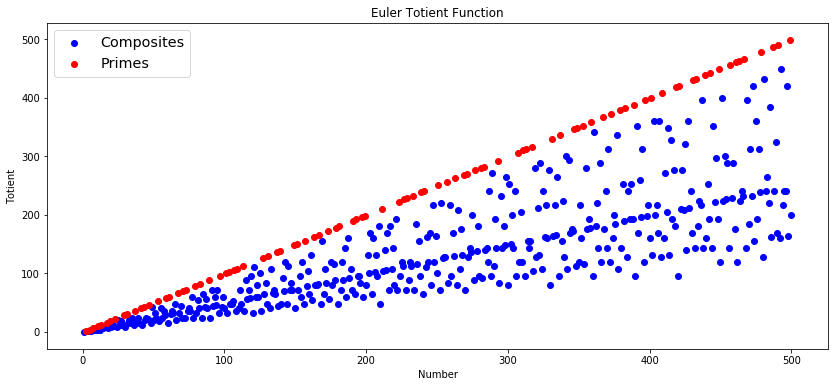

In [12]:
x_prime, x_comp = get_primes_composites(500)

y_prime = np.array([totient(x_prime[i]) for i in range(0, len(x_prime))])
y_comp = np.array([totient(x_comp[i]) for i in range(0, len(x_comp))])

plt.figure(figsize=(14, 6))
plt.scatter(x_comp, y_comp, color="blue", label="Composites")
plt.scatter(x_prime, y_prime, color="red", label="Primes")
plt.title("Euler Totient Function")
plt.ylabel("Totient")
plt.xlabel("Number")
plt.legend(fontsize="x-large")
plt.show()

Below is also an Euler Totient graph but this time it is calculated with compiled code and on multiple threads thus using all CPU's. This means more numbers can be shown. 

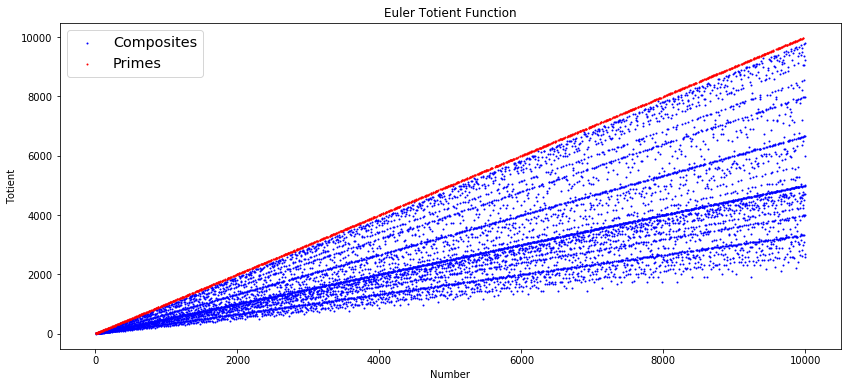

In [13]:
x_prime, x_comp = get_primes_composites(10000, is_prime_FUN=isprime_basic_fast)


y_prime = totient_fast_ufunc_par(x_prime)
y_comp = totient_fast_ufunc_par(x_comp)

plt.figure(figsize=(14, 6))
plt.scatter(x_comp, y_comp, color="blue", label="Composites", s=1)
plt.scatter(x_prime, y_prime, color="red", label="Primes", s=1)
plt.title("Euler Totient Function")
plt.ylabel("Totient")
plt.xlabel("Number")
plt.legend(fontsize="x-large")
plt.show()

### Note, forms of private key

If the private key is of the format $(p,q)$ where $N=pq$ given the public key $(N,e)$, the private key can be written in the format $(N,f)$ where $fe \equiv 1 \mod{\phi(N)}$ by the following code

In [14]:
def convert_to_N_f(prime_private_key, public_key):
    '''inputs private key of form two primes and public key
    outputs the new private key of form(N,f)'''
    p = prime_private_key["p"]
    q = prime_private_key["q"]
    N = public_key["N"]
    e = public_key["e"]

    if p*q != N:
        return "The private key does not work with public key"

    phi_N = (p-1)*(q-1)
    f = modular_inverse(e, phi_N)
    new_private_key = {"N": N, "f": f}
    return new_private_key

In [15]:
# Tests
prime_private_key = {"p": 41, "q": 61}
public_key = {"N": 2501, "e": 7}
private_key = convert_to_N_f(prime_private_key, public_key)
assert private_key == {"N": 2501, "f": 343}

## Examples of RSA Signature

### Example 1, no intruder

Bob wants to know the message he has been sent is from Alice. Therefore, Alice needs to generate private and public keys, sign the message. When Bob receives the message he has to verify the message is from Alice.

In [16]:
message = "Hello Bob my freind"
# Generate keys with 512 bit primes
private_key, public_key = Generation(512)

# Alice needs to sign message
s = Sign(message, private_key)

# s and message are sent to Bob
# Bob should also have access to the public key
# Bob will now verify Alice sent the message
Verification = Verify(message, s, public_key)
Verification

1

As can be seen the verification process passed so Bob knows Alice sent the message.

Sometimes with very small probability the prime generator will produce a composite number. However, this is fine as then the message will fail the verification process and then the signature process happens again.

### Example 2, intruder Dave

Bob wants to know the message he has been sent is from Alice. And that Dave has not captured and changed the message. Same as before  Alice needs to generate private and public keys, sign the message. When Bob receives the message he has to verify the message is from Alice. If the message fails verification Dave has changed the message. 

In [17]:
message = "Hello Bob my freind"
# Generate keys with 512 bit primes
private_key, public_key = Generation(512)

# Alice needs to sign message
s = Sign(message, private_key)

# s and message are sent to Bob
# Bob should also have access to the public key

# Dave intercepts the message and changes it
message = "I declare war on Bob"
# Dave sends new message to Bob

# Bob will now verify Alice sent the message
Verification = Verify(message, s, public_key)
Verification

0

The verification failed this means Bob knows that someone has intercepted and changed the message. 

### Example 3, 6 bit primes with tests and calculations

Let the message be hashed to $h$ where $h=15$, we will use 6 bit primes $p=41$ and $q=61$ so we get $N=2501$, we will use the fact that the Euler's totient function is multiplicative and $\phi{prime} = prime - 1$.
>$\phi{2501} = \phi{41}\phi{61} = 40*60 = 2400$

In [18]:
assert totient(2501) == 2400

We will select $e=7$ as $gcd(7,2400)=1$

calc by hand show working
if test then we get all pass

In [19]:
assert choose_e(2400) == 7

We need to solve for f
>\begin{align*}
ef &\equiv 1 \mod{\phi{N}}\\
7f &\equiv 1 \mod{2400}\\
f &= 343
\end{align*}

In [20]:
assert modular_inverse(7, 2400) == 343

Therefore, we get private key $(N=2501, f=343)$ and public key $(N=2501, e=7)$

In [21]:
private_key = {"N": 2501, "f": 343}
public_key = {"N": 2501, "e": 7}
message = 15

We need to sign the message, the signature $s$
>\begin{align*}
s &\equiv h^f \mod{N}\\
s &\equiv 15^{343} \mod{2501}\\
s &= 1053
\end{align*}

In [22]:
s = Sign(message, private_key)
assert s == 1053

The message and signature are sent off to the person, the person will verify the message by checking if their $h\prime = h$.

Let us consider the case where the message is not changed.

>\begin{align*}
h &\equiv s^e \pmod{N}\\
h &\equiv 1053^{7} \pmod{2501}\\
h &= 15
\end{align*}

So since $h\prime = h$ the message will be verified.

In [23]:
assert Verify(message, s, public_key) == 1

This time the same message is sent but a middle man intercepts the message and changes it. Let the new message be hashed to $h\prime=16$. Therefore, $h\prime \neq h$.


In [24]:
message = 16
assert Verify(message, s, public_key) == 0

The middle man will struggle to forge $s$ as they will struggle to find $f$ as they know $e$ and $N$ but only knowing that information makes solving $ef \equiv 1 \mod{\phi{N}}$ for $f$ difficult for large $N$ as $\phi{N}$ takes a long time to calculate.

## Problems with the Plain RSA signature

The Plain RSA signature is the same as the RSA-FDH signature but without the hash function $H$. This means only integers in $\{1,2,...,N-1\}$ can be sent as the message. With this signature there are a few forms of attacks.

### A no control of message attack,

This attack only requires the public key $(N,e)$, it works as follows. The attacker uniformly picks a signature $s$ where $s\in\{1,2,3,...,N-1\}$. Then calculates the message $h$ where 
>$h \equiv s^e \mod{N}$

Therefore, the message $h$ has a valid signature $s$, this is a forgery as no signatures were signed by the owner of the public key. However, the attacker has no control over the messages $h$ that get forged.

If this attack is repeated multiple times for different values of the signature $s$ then the attacker can pick a forged message which suits their needs.

### Forging a signature on an arbitary message

Say the attacker wants to forge a message $h\in\{1,2,3,...,N-1\}$ with respect to the public key $(N,e)$, then the attacker picks  $h_1,h_2\in\{1,2,3,...,N-1\}$ which is different from $h$ with
> $h \equiv h_1h_2\mod{N}$

The attacker then needs to obtain valid signatures $s_1, s_2$ for $h_1, h_2$. Then we have $s \equiv s_1s_2 \mod{N}$ is a valid signature for $h$. This is because
>$s^e \equiv (s_1s_2)^e \equiv (h_{1}^{f}h_{2}^{f})^e \equiv h_1^{fe}h_2^{fe} \equiv h_1h_2 \equiv h \mod{N}$

where $f$ is part of the private key, but isn't needed for this to work.

This may not seem devastating but it is dangerous to make assumptions about what messages the signer may or may not be willing to sign.

Additionally, multiple valid signatures $\textbf{s} = \{s_1, s_2, ..., s_q\}$ and their corresponding messages $\textbf{h} = \{h_1,h_2,...,h_q\}$ can be captured. By using the same principle as above the attacker can obtain a valid signature on any of the $2^q-q$ other messages by taking products of the subset $\textbf{h}$.

Furthermore, one example of getting signatures and messages is when a client wants to connect to a server. If a client uses a signature scheme to authenticate with the server and this is done by the client signing a random message sent by the server. It is easy for a malicious server to ask for a certain message to be signed.

## Hash Function

Let $m$ be a string message and $h$ be a hashed message such that $H(m) = h$

This means to prevent these attacks the hash function $H$ must have certain properties.
+ $H$ must be hard to invert, this will prevent the "no control of message attack". As for each valid signature that is forged it is difficult to find the string message $m$ which corresponds to the hashed message $h$

+ $H$ must not have multiplicative relations, that means it is hard to find three messages $m,m_1,m_2$ such that $H(m) = H(m_1)H(m_2)$. This should prevent the "forgery of an arbitrary message".

+ It must be hard to find collisions for $H$. Since if $H(m_1)=H(m_2)$, then $m_1$ and $m_2$ have the same signature, this means forgery of a non signed message is trivial.


## Core 6: The Diffie-Hellman Protocol

### Sophie Germain Prime

First, before discussing the Diffie-Hellman protcol, we will be discussing what a Sophie Germain prime is and why it is useful in many situations for cryptography. Simply a Sophie Germain prime is a prime $q$ such that $p = 2q+1$ is also a prime which is called the complimentary safe prime of the $q$. The complimentary safe prime is very useful due to one of the properties it exhibits, to see this property we look at the prime decomposition of $p-1$.

> $p - 1 = (2q + 1) - 1 = 2q$

By doing this we already have the prime decompostion of $p-1$, it is simply $2q$. Now if you're wondering why this is useful, we must first discuss primitive roots. 

A primitive root of a prime $p$ is a value we will call $a$, where $a$ is an integer such that the smallest value $l$, known as the multiplicative order of $a$ relative to $p$, for which,

> $a^{l} \equiv 1mod(p)$

is true is:

> $l = p-1$

It was proven by the German mathmatician Gauss, that all primes have a primitive root and that the amount of primitive roots a prime has is equal to  $\phi{(p-1)}$, where  $\phi$ is Eulers totient, so we do not have to worry about a lack of primitive roots. Now a useful fact we can use is that the multiplicative order of $a mod(p)$ will always be a divisior of $p-1$. Thus we have found the use for a Sophie Germain prime, since we know the prime factorization of $p-1$ where $p$ is the complementary safe prime to some Sophie Germain prime $p$, we can use this to easily test if a value $a$ is a primitive root of the complementary safe prime. To do this all we have to do is check if for the safe prime p, any of the following are true:

>$a^{1} \equiv 1mod(p)$

>$a^{2} \equiv 1mod(p)$

>$a^{\frac{(p-1)}{2}} \equiv 1mod(p)$

We only have to check this since we know the multiplicative order of $a mod(p)$ is a divisor of $2q$, so the multiplicative order must be $1,2$ or $q$, hence if none of the above are true, then the multiplicative order is $2q$ which means $a$ is a primitive root of our safe prime. This will get us started on the Diffie-Hellman protocol, so first we write a function to get Sophie Germain primes, and their complementary safe primes along with a function to get primitive roots for complementary safe primes.

In [ ]:
def sgrandprime(n_bit,t): 
    """This function returns a Sophie Germain prime, and its complementary safe prime."""
    while True: #Keeps searching untill we find a Sophie Germain prime
        bits = False
        while bits == False:
            p = random_prime(n_bit-1, t, trails = 500) # We generate random primes here
            if (2*p+1).bit_length() == n_bit:#We make sure the safe prime is of the desired bit length
                bits = True 
        if is_prime_miller_rabin((2*p)+1,t = 40): #Check if the random prime is Sophie germain
            return p, (2*p)+1



def safe_primitive_root(publicp):
    """This will return a primitive root for a given complementary safe prime
    for some Sophier Germain prime"""
    q = publicp[1] #Safe prime
    p = publicp[0] #Sophie germain prime
    b = 2 #Start checking for primitive roots starting from a value of 2
    primitive = False
    while not primitive: #Keeps searching untill primitive root is found
        if b%q == 1 or (b*b)%q == 1 or pow(b,p,q) == 1:   #if any of these are true, b is not a primitive root
            b += 1
            continue
        else: #if none are true, then b is a primitive root.
            primitive = True
    return b

### The Deffie-Hellman Protocol - First Steps

Before discussing the first steps of the Diffie-Hellman protocol, we will discuss what the protocol does. This protocol allows two or more parties (In cryptography the first two parties are usually referred to as Alice and Bob) to generate a shared secret key that each party knows, and has access to, without ever having to communicate the key in any form. The importance here is that the secret key is not communicated between parties, because if it is, the key is then suseptible to being observed by an outside party. Thus from this it is easy to see why the Deffie-Hellman protocol is so useful. An example of one of the main uses of this is that it allows parties say Alice and Bob to send encrypted messages to each other using the secret key and then decrypt these message using the same secret key. Hence if an outside party was to observe one of these messages, without the secret key they will not be able to read the message (at least without knowing how they encrypted the message and any potential cracks for this method).

So how does the Diffie-Hellman protocol work? First we will look at the two party situation, and we will call these parties Alice and Bob. To begin we need both Alice and Bob to have access to a very large safe prime $p$ (when discussing this protcol we will be using a 256 bit prime) and a primtive root of the prime we will call $g$, however unlike the secret key, $p$ and $g$ can be made public for anyone to have access to. Now when dicussing how the protocol works, you may soon notice that the safe prime Bob and Alice make public does not need to be a safe prime or even a prime at all and the primitive root can be any number for the protocol to work. Despite this we use a safe prime and a primitive root because hackers can calculate discrete logarithms (for example by using the Pohlig-Hellman protocol) to work out the secret key, however the algorithms hackers use is much faster if the number we make public here is not a safe prime, thus for security purposes we use a safe prime and one of the primitive roots for this prime. Hence by using our "sgrandprime" function above, we can generate a safe prime for Alice and Bob to use.

Now in the next step we want Alice and Bob to generate a private key for themselves, they can not tell each other about these keys nor anyone else, this is for them and only them to know and have access to. This private key is a random number, for alice we will call her private key $a$ and for Bob $b$, however the larger the private key again the better as it makes it harder for hackers to get access to the secret key so again we generate 256 bit random numbers. 

Below we will generate the safe prime $p$ and primitive root $g$ using the functions from before, also we will make a function to generate our the private keys $a$ and $b$.

In [ ]:

def Private_keys(n):
    """This function simply"""
    keys = []
    for i in range (0,n):
        bits = False
        while bits == False:
            x = ran.SystemRandom().getrandbits(256)
            if x.bit_length() == 256:
                keys.append(x)
                bits = True
    return keys

Publicprimes = sgrandprime(256,40)#Generate the primes to be used
p = Publicprimes[1]
g = safe_primitive_root(Publicprimes) # Get the primitive root of p
keys = Private_keys(2) #Generate the private keys for Alice and Bob (In a real scenorio, they will generate their key alone.)
a = keys[0]
b = keys[1]

### The Diffie-Hellman protocol - Generating Secret Key

Once Alice and Bob have their private keys, their next step is to generate their public keys. We will call the public key Alice generates $A$ and Bobs $B$. To generate these public keys we do the following calculations:

>$A = g^{a}mod(p)$

>$B = g^{b}mod(p)$

After we complete these calculations, we now have the public keys for Alice and Bob. The next step is for Alice to send her public key $A$ to Bob, and for Bob to send $B$ to Alice. Though this seems like a compromising step for a protocol based around security, for a hacker to use the public keys to get the private keys it is very difficult because $p$ is a safe prime and $g$ is a primitive root for $p$. By using these numbers a hacker has a very small amount of attack vectors when trying to find the private keys.

Once Alice has Bobs public key and Bob has Alices, we calculate the secret key that we will now call $S$. When calculating the secret key this must be done seperately by both Bob and Alice in private as to not let anyone gain access to the secret key. For Alice to generate the $S$ she must do the following calculation:

>$S = B^{a}$

and Bob must generate $S$ by calculating:

>$S = A^{b}$

This at first look may not be entirely obvious as to why the calculation Alice does calculates the same secret key as Bobs calculations. However this is due to simple properties of modulo exponents, as you can see below:

>$S = B^{a} = (g^{b}mod(p))^{a} = g^{ba}mod(p) = (g^{a}mod(p))^{b} = A^{b} = S$

However the calculations above only apply to a two party system. Luckily for us this generalizes quite simply for an $n$ party system. As before we have our safe prime $p$ and a primitive root of $p$ we call $g$, and all $n$ parties must generate their own private key in the same way as before and their relative public key in the same way as before. The only difference for an $n$ party system comes when calculating the secret key $S$. To do this let us label the n private keys generated as below:

> $P_{1}, P_{2}, ... , P_{n}$

Now all n parties have already calculated their relative public keys, which are as below:

> $g^{P_{1}}mod(p), g^{P_{2}}mod(p), ... , g^{P_{n}}mod(p)$

We want our final secret key $S$ to be of the same form before, meaning we have $g^{x}mod(p)$, where $x$ is the product of all private keys involved. Hence to achieve this in an n party case, we first label each party $1,2,..n$ and the $i^{th}$ party must send their public key to the $(i+1)^{th}$ party also party $n$ must give his public key to party $1$. Then each member must generate their new public key as below:

> $(g^{P_{n}}mod(p))^{P_{1}}, g^{P_{1}}mod(p))^{P_{2}}, ... , g^{P_{n-1}}mod(p))^{P_{n}}$

Once this has been completed, we again get each party to send their new public key to the party ahead of them. We repeat this process a total of $n-1$ times, and the final calculation will give each party the secret key $S$ which for the $i{th}$ party will be of the form:

> $(g^{P_{i-1}P_{i-2}...P_{1}P_{n}...P_{i+1}}mod(p))^{P_{i}} = g^{P_{1}P_{2}...P_{n}}mod(p) = S$

After all parties have the secret key $S$, they can send each other messages encrypted using the key $S$ and decrypt the messages they receive from one another. Below are the functions we use to achieve this.

In [ ]:
def Public_Keys(primiroot,Privates,Prime):
    """This function completed the neccessary calculation to calculate
    the Public keys for given private keys and safe prime"""
    n = len(Privates) #So we know how many Public keys we must generate 
    Publics = []
    for i in range (0,n):
        Publics.append(pow(primiroot,Privates[i],Prime)) #Calculation required to generate public keys
    return Publics 

Publics = Public_Keys(g,keys,p) #Generate the public keys for Alice and Bob 

A = Publics[0]
B = Publics[1]

def Secret_key_steps(publics, privates, generator):
    """This function completes all neccessary public key swaps between parties
    so that they all end up with the same Secret Key"""
    if str(publics).isdigit() == True: #This is to check if "publics" is one single public key (and not a list of many public
                                       # keys for the general n parties) and if yes then we make "publics" a list of
                                       # one key only
        publics = [publics]
    if str(privates).isdigit() == True:#This is to check if "privates" is one single private key (and not a list of many private
                                       # keys for the general n parties) and if yes then we make "privates" a list of
                                       # one key only
        privates = [privates]
    n = len(publics)
    if n == 1: #if n == 1 this means it is one person using the public key they have been given to calculate the next public
               # key or the final secret key, so we simple calclate this below.
        return(pow(publics[0], privates[0], generator))
    for m in range(0,n-1):  #For a party of length n, only have to complete this process n-1 times as mentioned above
        Temp = [] #Stores the current public key
        for i in range(0,n):
            Temp.append(pow(publics[(i-1)%n], privates[i], generator) )#Calculates current public key
        for j in range(0,n):    
            publics[j] = Temp[j]
    Final = Temp #After the final repeated is complete "Temp" will be equal to the secret key
    return Final

Alice_S = Secret_key_steps(B,a,p)#Alices calculation for the Secret key
Bob_S = Secret_key_steps(A,b,p)#Bobs calculation for the Secret key

print("Alice calculates the secret key to be",Alice_S,", and Bob calculates the secret key to be", Bob_S, ". Hence they both have the same secret key")

### Alice and Bob - Sending a Message

Now that Alice and Bob have both calculated the secret key independently without ever communicating the key with one anoher, they both now have access to a key which they can use to encrypt and decrypt messages they send to each other. Below is an example of how they can do this.

In [ ]:
#Below is an example of Alice encrypting a message using the Vigenere cipher using the calculated secret key
Alice_message = Vigenere_cipher_ext("Hello Bob, I'm sending this message to you with the hopes that you have calculated the secret key, so that we can now communicate in private", str(Alice_S), "encrypt")
#Below is how Bob will decrypt Alices message using the secret key
Bob_decryption = Vigenere_cipher_ext(Alice_message, str(Bob_S), "decrypt")

print("Thus Alice has encrypted her message using the key, to get the encrypted message - ", Alice_message,".Bob now decrypts this message using the secret key to get -", Bob_decryption)

### Three Party Example

As I mentioned above, the functions we created were generalized for n people, so to carry out this protocol for a 3 party scenorio is very simple. Below is an example of our code working for 3 partys.

In [ ]:
#Example of this being used to generate a secret key for a 3 party system

threekeys = Private_keys(3) #These will be the 3 private keys for our parties, however they would in a real scenorio
                            #be computed alone on each persons computer

Three_Alice_private = threekeys[0]
Three_Bob_private = threekeys[1]
Three_Charlie_private = threekeys[2]

Three_Public = Public_Keys(g,threekeys,p) #Now they all calculate their intial public key 

Three_Alice_public1 = Three_Public[0] 
Three_Bob_public1 = Three_Public[1]
Three_Charlie_public1 = Three_Public[2]

General_function_keys = Secret_key_steps(Three_Public,threekeys,p) #This does the final step where each public key is passed to each party
                                                   #as many times as is needed for all parties to have the same secret key
                                                   #however again, this would in a real scenorio be done multiple times 
                                                   #alone.

#However if we were to do this manually alone as in a real scenorio, we will follow what each party must do below:

#First each party must pass their public key to the next part in the line

#Below each party must now calculate their second public key and pass this to the next party to calculate the secret key

Three_Alice_public2 = Secret_key_steps(Three_Charlie_public1,Three_Alice_private,p)
Three_Bob_public2 = Secret_key_steps(Three_Alice_public1,Three_Bob_private,p)
Three_Charlie_public2 = Secret_key_steps(Three_Bob_public1,Three_Charlie_private,p)

#Now as this is only a 3 party scenorio, we have one final step to calculate the Secret key below:

Three_Alice_S = Secret_key_steps(Three_Charlie_public2,Three_Alice_private,p)
Three_Bob_S = Secret_key_steps(Three_Alice_public2,Three_Bob_private,p)
Three_Charlie_S = Secret_key_steps(Three_Bob_public2,Three_Charlie_private,p)

print("The keys we generated using our general function were:")
print(General_function_keys)
print("The independelty calculated keys were:")
print("Alices S -", Three_Alice_S)
print("Bobs S -", Three_Bob_S)
print("Charlies S -", Three_Charlie_S)
print("As you can see their all equal, whever we use our general function, or do it indepently")

### The Diffie-Hellman protocol - Function notes

The functions we have created above are generalized functions as I mentioned before, hence they are good for show casing how the protocol works for both a 2 party system and for an n party system. However as mentioned when implementing the The Diffie-Hellman protocol in a real world scenorio these calculations should be done in private for one person. This means you should not use the functions as I have above to calculate private keys, public keys and the secret key for each party in the system on one computer. Instead you will use the functions to only calculate everything for yourself in privacy, as if everything was done from one computer, this would negate the entire process.

## Solving the discrete logarithm problem

The discrete logarithm problem is finding $a \in \mathbb{N}$ such that it solves
> $M \equiv g^a\mod{p}$

where $M,g,p \in \mathbb{N}$

So far there are no discrete logarithm algorithms that work in polynomial time on a classical computer. However, there are algorithms in quantum computing like Shor's algorithm that are efficient, this algorithm is for breaking down an integer into its prime factors. But it can be modified to solve the discrete logarithm problem.

A time function will be used to time the function. Therefore, different methods can be compared. This time function can be used to time any function. 

In [27]:
def time_func(Func, num_samples, Func_parameters=[[]]):
    """Times the function

    Parameters
    ----------
    Func : function
        Function that is being timed 
    num_samples : int
        Number of times Func will run
    Func_parameters : 2D array
        Each array in 2D array are the parameters of the Function Func, if num_samples
        greater than number of arrays then it will loop over

    Returns
    -------
    tuple
        mean_time,
        std_time


    Examples
    --------
    time_func(decompose, 4, [[3226322291321]])   
    #will time decompose function 4 times with parameter 3226322291321

    time_func(decompose, 3, [[3304575252941], [1954377239027], [2964234252593]])   
    #will time decompose function 3 times with a differenc parameter each time


    """
    times = np.zeros(num_samples)
    loopover = len(Func_parameters)
    for i in range(num_samples):
        temp_start_time = time.time()
        Func(*Func_parameters[i % loopover])
        temp_finish_time = time.time()
        times[i] = (temp_finish_time - temp_start_time)

    return times.mean(), times.std()

We will now create a function which times how long each discrete logarithm algorithm takes with different bit sizes. It outputs a pandas data frame.

In [28]:
def time_discrete_logarithm(Func, start, stop, num_samples=10):
    r"""time_discrete_logarithm

    Times how long a discrete logarithm algorithm takes to run.
    Outputs a pandas data frame with the results.

    Parameters
    ----------
    Func : Func
        The function that is to solve the discrete logarithm
    start : int
        The bit size to start at
    stop : int
        The bit size to stop at, does not include stop size bit
    num_samples : int, optional
        The number of samples to be taken.  Defaults to 10

    Returns
    -------
    pandas data frame
        index: bit size of p and q
        Mean time: Has the mean time
        Std time: Has the std times

    """

    discrete_logarithm_mean_times = []
    discrete_logarithm_std_times = []

    for n_bit in range(start, stop):
        public_keys = [gen_public_key(n_bit) for i in range(num_samples)]

        input_parameters = format_input_parameters(public_keys)
        temp_mean, temp_std = time_func(
            Func, num_samples, input_parameters)

        discrete_logarithm_mean_times.append(temp_mean)
        discrete_logarithm_std_times.append(temp_std)

    #print("discrete_logarithm_brute_better_fast(g, p, A)")

    my_time_data = {"Mean time": discrete_logarithm_mean_times,
                    "Std time": discrete_logarithm_std_times}
    time_data_frame = pd.DataFrame(data=my_time_data)
    time_data_frame.index = range(start, stop)
    time_data_frame.index.name = "bit size of p and a"

    return time_data_frame


def gen_public_key(n_bit):
    """generates public information

    Generates then calculates public information

    Parameters
    ----------
    n_bit : int
        The size of the p prime wanted

    Returns
    -------
    dict
        The public information
        A : solution to g^a mod(p)
        g : primitive root
        p : large n_bit prime

    """
    q, p = sgrandprime(n_bit, 40)
    g = safe_primitive_root([q, p])
    a = Private_keys(n_bit)[0]
    A = pow(g, a, p)
    return {"A": A, "g": g, "p": p}


def format_input_parameters(public_keys, my_order=["g", "p", "A"]):
    """Formats parameters for the function


    Parameters
    ----------
    public_keys : array of dict

    my_oreder : array of str
        What order is wanted for the output

    Returns
    -------
    2D array
        The parameters for the funciton

    """

    formated_public_keys = []

    for public_key in public_keys:
        temp_public_key = []
        for key in my_order:
            temp_public_key.append(public_key[key])
        formated_public_keys.append(temp_public_key)

    return formated_public_keys

In [29]:
# Test format_input_parameters
input_public_keys = [{"A": 307, "g": 5, "p": 863},
                     {"g": 5, "A": 844, "p": 983},
                     {"p": 563, "g": 2, "A": 83}]
expected_format = [[5, 863, 307],
                   [5, 983, 844],
                   [2, 563, 83]]
assert format_input_parameters(input_public_keys) == expected_format

As solving the discrete logarithm problem has time complexity of $\mathcal{O}(2^N)$, we will need a way of finding the curve of best fit in order to predict run times of higher bit numbers.

In [30]:
def log_best_fit(x, y):
    """Finds the best fit values for alpha, beta

    y = alpha*e^(x*beta)

    Parameters
    ----------
    y : array of floats

    x : array of floats

    Returns
    -------
        turple of float
        alpha, beta
        The parameters for the funciton

    """
    x = np.array(x)
    y = np.array(y)
    # Need to disregard any y=0
    index_of_0 = np.where(y == 0)
    x = np.delete(x, index_of_0)
    y = np.delete(y, index_of_0)

    ln_y = np.log(y)

    ln_alpha, beta = best_fit(x, ln_y)
    alpha = np.e**ln_alpha

    return alpha, beta


def best_fit(x, y):
    """Finds the best fit values for alpha, beta

     y = beta*x + alpha


    Parameters
    ----------
    y : array of floats

    x : array of floats

    Returns
    -------
        turple of float
        alpha, beta
        The parameters for the funciton

    """
    x = np.array(x)
    y = np.array(y)

    n = len(x)
    S_xx = sum(x**2)-((sum(x))**2/n)
    S_xy = sum(x*y)-(sum(x)*sum(y)/n)

    beta = S_xy/S_xx
    alpha = y.mean() - beta*x.mean()

    return alpha, beta


def get_prediction(df, start=1, stop=5, step=0.5, ab=False):
    """Get prediction of what further times will be

    Uses linear and exponential regression to predict future times,
    By solving
        y = alpha*e^(x*beta)

    Parameters
    ----------
    df : pandas data frame
        Contains the time it takes for a n bit prime to be solved in discrete logarithum problem.
    start : float, optional
        the n_bit position to start the returned line.
    stop: float, optional
        the n_bit position to finish the returned line, does not include end. 
    step: float, optional
        the smaller the number the higher the detail of the line, defaults to 0.5 .
    ab: boolean, optional
        If the alpha and beta want to be returned instead, defaults to false.

    Returns
    -------
        turple of float arrays
        Points of the predicted line

        alpha, beta
        Curve of best fit

    """
    # process df
    n_bit = np.array(df.index)
    times = np.array(df)

    # find curve of best fit
    alpha, beta = log_best_fit(n_bit, times)

    if ab:
        return alpha, beta

    # get points
    x_vals = np.arange(start, stop, step)
    y_vals = alpha*(np.e**(beta*x_vals))

    return x_vals, y_vals


def calc_time(x, alpha, beta, inverse=False):
    """Maths function for Calculating time

    Calculates
        y = alpha*e^(x*beta)

    Parameters
    ----------
    x : float
    alpha: float
    beta: float
    inverse: boolean, optional
        if true solves the inverse of the function, defaults to False.
    """
    if inverse:
        return (np.log(x)-np.log(alpha))/beta
    else:
        return alpha*(np.e**(x*beta))

In [31]:
# Test best_fit()
test_x = [1, 3, 4]
test_y = [5, 9, 11]
test_alpha, test_beta = best_fit(test_x, test_y)
assert abs(test_alpha - 3) < 0.001
assert abs(test_beta - 2) < 0.001

# Test log_best_fit()
test_x = [0, 1, 2, 3, 4, 5]
test_y = [3, 7, 10, 24, 50, 95]
test_alpha, test_beta = log_best_fit(test_x, test_y)
assert abs(test_alpha - 3.0465) < 0.001
assert abs(test_beta - 0.6871) < 0.001

# Test get prediction
test_df = pd.DataFrame(data={'test data': [3, 7, 10, 24, 50, 95]})
expected_y_vals = [23.934, 47.579, 94.584]
actual_x_vals, actual_y_vals = get_prediction(test_df['test data'], 3, 6, 1)

assert max(abs(actual_x_vals - [3, 4, 5])) < 1e-5
assert max(abs(actual_y_vals - expected_y_vals)) < 1e-1


# Test calc_time()
alpha = 3
beta = 2
x = 4
expected_y = 8942.873961
assert abs(calc_time(x, alpha, beta) - expected_y) < 1e-4

y = 1000
expected_x = 2.90457
assert abs(calc_time(y, alpha, beta, inverse=True) - expected_x) < 1e-4

### Using Brute Force

Here we have a basic brute force method. This method works by starting with $a=1$ then evaluating $g^a\mod{p}$ and comparing it to $M$. By incrementing $a$ until a solution is found.

This method only works if there is a solution for $a$ as "discrete_logarithm_brute(2,4,3)" will run forever. Since this is being used to crack the Diffie-Hellman protocol then there has to be a solution, so this problem can be disregarded.

To make the code run faster numba will be used. This will allow the code to be compiled before running, this means the start up time of a function will be longer but since these methods have many loops the time to complete will be reduced.

In [32]:
def discrete_logarithm_brute(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """

    b = 1
    while True:
        if pow(a, b, N) == z:
            return b
        b += 1


@numba.jit('int64(int64,int64,int64)', nopython=True)
def discrete_logarithm_brute_fast(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """

    b = 1
    while True:
        if my_pow(a, b, N) == z:
            return b
        b += 1

In [33]:
# Tests
# Brute
assert discrete_logarithm_brute(15, 2342, 167) == 37
assert discrete_logarithm_brute(5, 352, 133) == 25
assert discrete_logarithm_brute(3452, 123456, 39104) == 543

for n_bit in range(3, 20):
    test_dict = gen_public_key(n_bit)
    g = test_dict['g']
    p = test_dict['p']
    A = test_dict['A']
    b = discrete_logarithm_brute(g, p, A)
    assert pow(g, b, p) == A

# Compiled Brute
assert discrete_logarithm_brute_fast(15, 2342, 167) == 37
assert discrete_logarithm_brute_fast(5, 352, 133) == 25
assert discrete_logarithm_brute_fast(3452, 123456, 39104) == 543

for n_bit in range(3, 20):
    test_dict = gen_public_key(n_bit)
    g = test_dict['g']
    p = test_dict['p']
    A = test_dict['A']
    b = discrete_logarithm_brute_fast(g, p, A)
    assert pow(g, b, p) == A

The method below is still a brute force method. It uses information from the previous loop which means it doesn't have to evaluate $g^a\mod{p}$ every time. However, this comes at the price of using extra storage space which increase space complexity.

In [34]:
def discrete_logarithm_brute_better(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """
    b = 1
    a_new = a
    while True:
        if a_new == z:
            return b
        a_new = (a_new*a) % N
        b += 1


@numba.jit('int64(int64,int64,int64)', nopython=True)
def discrete_logarithm_brute_better_fast(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method, uses a complied version

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """
    b = 1
    a_new = a % N
    while True:
        if a_new == z:
            return b
        a_new = (a_new*a) % N
        b += 1

In [35]:
# Tests
# Better Brute
assert discrete_logarithm_brute_better(15, 2342, 167) == 37
assert discrete_logarithm_brute_better(5, 352, 133) == 25
assert discrete_logarithm_brute_better(3452, 123456, 39104) == 543

for n_bit in range(3, 24):
    test_dict = gen_public_key(n_bit)
    g = test_dict['g']
    p = test_dict['p']
    A = test_dict['A']
    b = discrete_logarithm_brute_better(g, p, A)
    assert pow(g, b, p) == A


# Compiled Better Brute
assert discrete_logarithm_brute_better_fast(15, 2342, 167) == 37
assert discrete_logarithm_brute_better_fast(5, 352, 133) == 25
assert discrete_logarithm_brute_better_fast(3452, 123456, 39104) == 543

for n_bit in range(3, 29):
    test_dict = gen_public_key(n_bit)
    g = test_dict['g']
    p = test_dict['p']
    A = test_dict['A']
    b = discrete_logarithm_brute_better_fast(g, p, A)
    assert pow(g, b, p) == A

### Comparing Brute Force Methods

By comparing these functions it is clear to see that the brute better algorithm is faster. Additionally, the algorithms which are compiled are faster. So from using a better brute force method and compiled code we get the solution runs over $100$ times faster.

In [37]:
%timeit discrete_logarithm_brute(3452, 123456, 39104)
%timeit discrete_logarithm_brute_fast(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better_fast(3452, 123456, 39104)

603 µs ± 4.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
262 µs ± 2.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
56.6 µs ± 374 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.38 µs ± 21.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
read_times = True
dl_brute_time_file_name = 'Discrete Logarithm Brute Times.csv'
dl_brute_fast_time_file_name = 'Discrete Logarithm Compiled Brute Times.csv'
dl_brute_better_time_file_name = 'Discrete Logarithm Better Brute Times.csv'
dl_brute_better_fast_time_file_name = 'Discrete Logarithm Compiled Better Brute Times.csv'

In [37]:
# Brute
if os.path.exists('data/' + dl_brute_time_file_name) and read_times:
    # read
    dl_brute_times = pd.read_csv(
        'data/' + dl_brute_time_file_name, index_col=0)
else:
    # Create times
    dl_brute_times = time_discrete_logarithm(
        discrete_logarithm_brute, 8, 22, 20)  # 21
    # Save times
    dl_brute_times.to_csv('data/' + dl_brute_time_file_name)

In [38]:
# Compiled Brute
if os.path.exists('data/' + dl_brute_fast_time_file_name) and read_times:
    # read
    dl_brute_fast_times = pd.read_csv(
        'data/' + dl_brute_fast_time_file_name, index_col=0)
else:
    # Create times
    dl_brute_fast_times = time_discrete_logarithm(
        discrete_logarithm_brute_fast, 10, 23, 20)  # 23
    # Save times
    dl_brute_fast_times.to_csv('data/' + dl_brute_fast_time_file_name)

In [39]:
# Better Brute
if os.path.exists('data/' + dl_brute_better_time_file_name) and read_times:
    # read file
    dl_brute_better_times = pd.read_csv(
        'data/' + dl_brute_better_time_file_name, index_col=0)
else:
    # Create times
    dl_brute_better_times = time_discrete_logarithm(
        discrete_logarithm_brute_better, 12, 27, 20)  # 26
    # Save times
    dl_brute_better_times.to_csv('data/' + dl_brute_better_time_file_name)

In [40]:
# Compiled Better Brute
if os.path.exists('data/' + dl_brute_better_fast_time_file_name) and read_times:
    # read file
    dl_brute_better_fast_times = pd.read_csv(
        'data/' + dl_brute_better_fast_time_file_name, index_col=0)
else:
    # Create times
    dl_brute_better_fast_times = time_discrete_logarithm(
        discrete_logarithm_brute_better_fast, 13, 30, 20)  # 29
    # Save times
    dl_brute_better_fast_times.to_csv(
        'data/' + dl_brute_better_fast_time_file_name)

In [41]:
MT = 'Mean time'
ST = 'Std time'

df = pd.DataFrame({'0': dl_brute_times[MT], '1': dl_brute_times[ST],
                   '2': dl_brute_fast_times[MT], '3': dl_brute_fast_times[ST],
                   '4': dl_brute_better_times[MT], '5': dl_brute_better_times[ST],
                   '6': dl_brute_better_fast_times[MT], '7': dl_brute_better_fast_times[ST]})

columns = [('Brute', MT), ('Brute', ST),
           ('Compiled Brute', MT), ('Compiled Brute', ST),
           ('Better Brute', MT), ('Better Brute', ST),
           ('Compiled Better Brute', MT), ('Compiled Better Brute', ST)]

df.columns = pd.MultiIndex.from_tuples(columns)
df.index.name = "bit size of p and a"
df

Brute           Compiled Brute           Better Brute  \
                    Mean time  Std time      Mean time  Std time    Mean time   
bit size of p and a                                                             
8                    0.000100  0.000299            NaN       NaN          NaN   
9                    0.000199  0.000398            NaN       NaN          NaN   
10                   0.000349  0.000475       0.000198  0.000396          NaN   
11                   0.000698  0.000457       0.000399  0.000582          NaN   
12                   0.001346  0.001149       0.000648  0.000790     0.000150   
13                   0.003291  0.001726       0.002294  0.001549     0.000399   
14                   0.006483  0.004477       0.004388  0.002451     0.000547   
15                   0.018499  0.006378       0.008876  0.006049     0.001397   
16                   0.026430  0.020753       0.019598  0.011823     0.001795   
17                   0.067724  0.036870       0.042885  0.028257     0.006035   
18                   0.134511  0.111052       0.103724  0.081495     0.012623   
19                   0.272963  0.174934       0.245818  0.119902     0.019847   
20                   0.712018  0.403627       0.412038  0.288008     0.038611   
21                   1.266637  0.992773       0.798526  0.554147     0.069914   
22                        NaN       NaN       2.268860  1.311378     0.193168   
23                        NaN       NaN            NaN       NaN     0.331391   
24                        NaN       NaN            NaN       NaN     0.700729   
25                        NaN       NaN            NaN       NaN     1.309305   
26                        NaN       NaN            NaN       NaN     2.608662   
27                        NaN       NaN            NaN       NaN          NaN   
28                        NaN       NaN            NaN       NaN          NaN   
29                        NaN       NaN            NaN       NaN          NaN   

                              Compiled Better Brute            
                     Std time             Mean time  Std time  
bit size of p and a                                            
8                         NaN                   NaN       NaN  
9                         NaN                   NaN       NaN  
10                        NaN                   NaN       NaN  
11                        NaN                   NaN       NaN  
12                   0.000356                   NaN       NaN  
13                   0.000489              0.000000  0.000000  
14                   0.000584              0.000051  0.000224  
15                   0.000801              0.000150  0.000356  
16                   0.001564              0.000199  0.000399  
17                   0.003211              0.000499  0.000499  
18                   0.006463              0.000748  0.000696  
19                   0.013860              0.002244  0.001408  
20                   0.023594              0.004240  0.002710  
21                   0.038134              0.006732  0.003440  
22                   0.106035              0.010972  0.006385  
23                   0.222300              0.030525  0.014978  
24                   0.397034              0.075002  0.036512  
25                   1.005868              0.129564  0.068549  
26                   1.882304              0.194701  0.096763  
27                        NaN              0.504743  0.289034  
28                        NaN              1.068457  0.553211  
29                        NaN              2.228350  1.460594

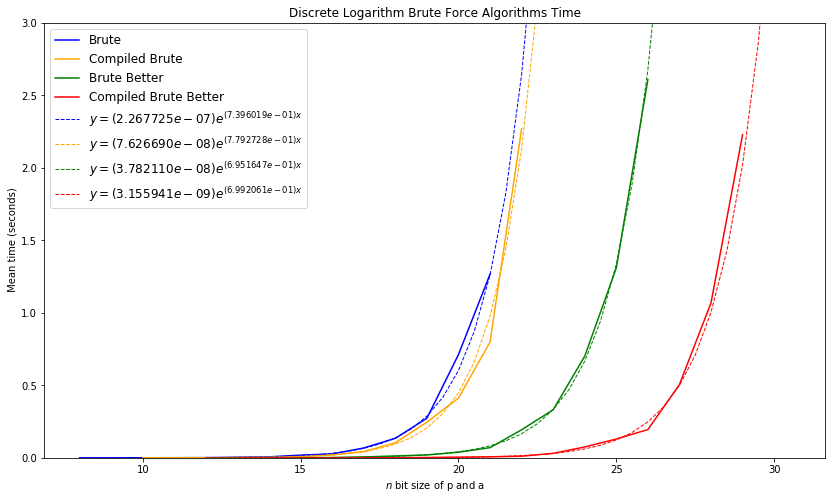

In [42]:
# Make plot
plt.figure(figsize=(14, 8))
# Plot data
plt.plot(dl_brute_times['Mean time'], label='Brute', color='Blue')
plt.plot(dl_brute_fast_times['Mean time'],
         label='Compiled Brute', color='orange')
plt.plot(dl_brute_better_times['Mean time'],
         label='Brute Better', color='green')
plt.plot(dl_brute_better_fast_times['Mean time'],
         label='Compiled Brute Better', color='red')

# The extrapolated curves
plt.plot(*get_prediction(dl_brute_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="blue",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_fast_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="orange",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_fast_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_better_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="green",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_better_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_better_fast_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="red",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_better_fast_times[MT],
                                                          ab=True)))

plt.ylim(0, 3)
plt.legend(loc="upper left", prop={"size": 12})
plt.xlabel(r"$n$ bit size of p and a")
plt.ylabel(r" Mean time (seconds)")
plt.title(r"Discrete Logarithm Brute Force Algorithms Time")
# plt.yscale('log')

plt.show()

The dashed lines are extrapolated data.

###  Baby step/Giant step

We are trying to solve for $x$
> $a^x \equiv b \mod{N}$

Let $k\in \mathbb{N}$, set $x = mk + n$ where $m,n \in \mathbb{N}$ such that

>\begin{align*}
&a^{mk+n} \equiv b \mod{N}\\
\iff &a^{n} \equiv ba^{-mk} \mod{N}
\end{align*}

So we are looking for $n,m \in \mathbb{N}$ to satisfy the equation above. We know $0 \leq n < k$, since if $n=k$ then $m$ could be increased and $n$ reduced.
To find this solution we evaluate
>\begin{align*}
&a,a^{2},...,a^{k-1}\mod{N}\\
&ba^{-k}, ba^{-2k}, ..., ba^{-rk}\mod{N}
\end{align*}

until $rk>N$

Stop when $rk>N$ as the order of any element $a$ has to be less than N. Then find the values that are equivalent, this gives a valid value for $m,n$. If none of them are the same then there is no solution.

This algorithm has time complexity and space complexity $\mathcal{O} (\sqrt{n})$ where $n$ is the order of the cyclic group formed by $a^x\mod{N}$

An important note is that this algorithm only works when $N$ is prime.

In [43]:
def discrete_logarithm_step(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using the baby step, giant step method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
        if recieved -1 then there is no solution
    """
    k = int(np.floor(N**0.5 + 1))
    a_to_k = {pow(a, power, N): power for power in range(k)}
    ab = pow(a, k * (N - 2), N)

    #power = 0
    if z % N in a_to_k:
        n = a_to_k[(z % N)]
        return n

    new_ab = ab
    for power in range(1, k):
        val = z*new_ab % N
        new_ab = new_ab*ab % N
        if val in a_to_k:
            n = a_to_k[val]
            m = power
            return m*k + n

    # No solution
    return -1

In [44]:
# Tests
assert discrete_logarithm_step(3, 59, 19) == 17
assert discrete_logarithm_step(2, 306707, 210153) == 3648
assert discrete_logarithm_step(2, 67422227, 63257631) == 1075556


for n_bit in range(3, 33):
    test_dict = gen_public_key(n_bit)
    g = test_dict['g']
    p = test_dict['p']
    A = test_dict['A']
    b = discrete_logarithm_step(g, p, A)
    assert pow(g, b, p) == A

#### Example of Baby Step/Giant Step

We will solve 
> $7^x \equiv 13 \mod{33}$

Therefore, we will let $a=7$, $b=13$, $N=33$ and set $k=Ceiling(\sqrt(N))=6$. As this is the value of $k$ in the code.

First we calculate the sequence

>\begin{align*}
&a^{0},&a^{1},& &a^2,& &a^3,& &a^4,& &a^5,& \mod{N}\\
&1,&{7},& &16,&  &\underline{13},&  &25,&  &10,& \mod{33}
\end{align*}

Then calculate the modular inverse,

>\begin{align*}
aa^{-1} &\equiv 1\mod{N}\\
77^{-1} &\equiv 1\mod{33}\\
7^{-1} &\equiv 19\mod{33}
\end{align*}

Now calculate
>\begin{align*}
&ba^{-0k},& &ba^{-k},& &ba^{-2k},& &ba^{-3k},& &ba^{-4k},& &ba^{-5k},& &ba^{-6k},& \mod{N}\\
&13\cdot 7^{0},& &13\cdot 7^{-6},& &13\cdot 7^{-12},& &13\cdot 7^{-18},& &13\cdot 7^{-24},& &13\cdot 7^{-30},& &13\cdot 7^{-36},& \mod{33}\\
&\underline{13},& &28,& &7,&  &10,&  &19,&  &13,& &28,&\mod{33}
\end{align*}

We then find the value which is in both lists, in this case there are multiple. We pick the one which gives the smallest value for $x$. In the code it observes 'ba' values first and compares it to 'a_to_k' this will guarantee the smallest $x$. 

We have
> $b\cdot a^{-0\cdot6}\equiv 7 \equiv a^3 \mod{33}$

Which leads to 
> $b \equiv a^{3 + 0 \cdot 6} \mod{33}$

So $x=3$

In [45]:
# Now check code folows example
assert discrete_logarithm_step(7, 33, 13) == 3

#### Fast version

In [46]:
@numba.jit(nopython=True)
def isin(element, the_list):
    for selected_element in the_list:
        if element == selected_element:
            return True
    return False


@numba.jit(numba.int64(numba.uint64, numba.uint64, numba.uint64), nopython=True)
def discrete_logarithm_step_fast(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using the baby step, giant step method, compiled 
    Works up to 16 bit public key

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
        if recieved -1 then there is no solution
    """
    k = numba.uint64(np.floor(N**0.5 + 1))

    a_to_k = np.zeros(k, dtype = numba.uint64)
    a_to_k[0] = 1
    a_to_k[1] = numba.uint64(a)
    for i in range(2, k):
        a_to_k[i] = my_pow(a*a_to_k[i-1], 1, N)
    r = 1
    ab = my_pow(a, k*(N-2), N)

    #power = 0
    if isin(z%N,a_to_k):
        n = np.where(a_to_k == z%N)[0][0]
        return n
    
    new_ab = ab
    for power in range(1,k):
        val = z*new_ab % N
        new_ab = new_ab*ab % N
        if isin(val, a_to_k):
            n = np.where(a_to_k == val)[0][0]
            m = power
            return m*k + n

    # No solution
    return -1

In [47]:
# Tests

assert isin(2, np.array([1, 4, 6, 2]))
assert not isin(3, np.array([1, 4, 6, 2]))

assert discrete_logarithm_step_fast(7, 33, 13) == 3
assert discrete_logarithm_step_fast(3, 59, 19) == 17



# Only works up to 26-bit as pow function can't go higher without overflow
for n_bit in range(5, 27):
    test_dict = gen_public_key(n_bit)
    g = test_dict['g']
    p = test_dict['p']
    A = test_dict['A']
    b = discrete_logarithm_step_fast(g, p, A)
    assert pow(g, b, p) == A


### Comparing Baby/Giant Steps Methods

By comparing these functions it is clear to see that the algorithms which are compiled are faster. So from using a compiled version we get the solution runs over $80$ times faster. Because of the overflow error the fast version encounters it sadly can't be used for larger bits.

In [50]:
%timeit discrete_logarithm_step(3452, 123456, 39104)
%timeit discrete_logarithm_step_fast(3452, 123456, 39104)

401 µs ± 761 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
12.4 µs ± 610 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [48]:
read_times = True
dl_step_time_file_name = 'Discrete Logarithm Step Times.csv'
dl_step_fast_time_file_name = 'Discrete Logarithm Compiled Step Times.csv'

In [49]:
# Step
if os.path.exists('data/' + dl_step_time_file_name) and read_times:
    # read
    dl_step_times = pd.read_csv(
        'data/' + dl_step_time_file_name, index_col=0)
else:
    dl_step_times = time_discrete_logarithm(
        discrete_logarithm_step, 20, 42, 20)  # 42
    # Save times
    dl_step_times.to_csv('data/' + dl_step_time_file_name)

In [50]:
# Compiled Step
if os.path.exists('data/' + dl_step_fast_time_file_name) and read_times:
    # read
    dl_step_fast_times = pd.read_csv(
        'data/' + dl_step_fast_time_file_name, index_col=0)
else:
    dl_step_fast_times = time_discrete_logarithm(
        discrete_logarithm_step_fast, 10, 26, 20)  # 26
    # Save times
    dl_step_fast_times.to_csv('data/' + dl_step_fast_time_file_name)

In [51]:
MT = 'Mean time'
ST = 'Std time'

df = pd.DataFrame({'0': dl_step_times[MT], '1': dl_step_times[ST],
                   '2': dl_step_fast_times[MT], '3': dl_step_fast_times[ST]})

columns = [('Step', MT), ('Step', ST),
           ('Compiled Step', MT), ('Compiled Step', ST)]

df.columns = pd.MultiIndex.from_tuples(columns)
df.index.name = "bit size of p and a"
df

Step           Compiled Step          
                    Mean time  Std time     Mean time  Std time
bit size of p and a                                            
10                        NaN       NaN      0.000000  0.000000
11                        NaN       NaN      0.000000  0.000000
12                        NaN       NaN      0.000000  0.000000
13                        NaN       NaN      0.000050  0.000217
14                        NaN       NaN      0.000000  0.000000
15                        NaN       NaN      0.000000  0.000000
16                        NaN       NaN      0.000000  0.000000
17                        NaN       NaN      0.000050  0.000217
18                        NaN       NaN      0.000050  0.000217
19                        NaN       NaN      0.000100  0.000299
20                   0.001247  0.000433      0.000199  0.000399
21                   0.001695  0.000457      0.000299  0.000457
22                   0.002542  0.000500      0.000598  0.000659
23                   0.003541  0.000499      0.001496  0.000919
24                   0.004937  0.000738      0.002295  0.001643
25                   0.007629  0.000904      0.004987  0.002560
26                   0.010273  0.001269           NaN       NaN
27                   0.015906  0.001322           NaN       NaN
28                   0.022290  0.002050           NaN       NaN
29                   0.033712  0.004918           NaN       NaN
30                   0.050515  0.005204           NaN       NaN
31                   0.096343  0.015807           NaN       NaN
32                   0.140982  0.018785           NaN       NaN
33                   0.228604  0.028669           NaN       NaN
34                   0.344129  0.046345           NaN       NaN
35                   0.487112  0.060990           NaN       NaN
36                   0.688357  0.084496           NaN       NaN
37                   1.023354  0.101297           NaN       NaN
38                   1.494604  0.207891           NaN       NaN
39                   2.279893  0.285160           NaN       NaN
40                   3.184828  0.414893           NaN       NaN
41                   5.074225  0.537644           NaN       NaN

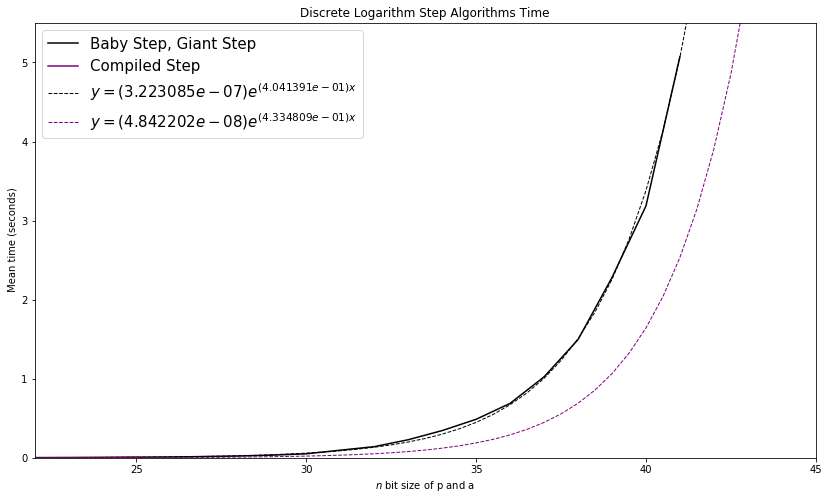

In [52]:
# Make plot
plt.figure(figsize=(14, 8))
# Plot data
plt.plot(dl_step_times['Mean time'],
         label='Baby Step, Giant Step', color='black')
plt.plot(dl_step_fast_times['Mean time'],
         label='Compiled Step', color='purple')


# The extrapolated curves
plt.plot(*get_prediction(dl_step_times[MT], 12, 45), linewidth=1,
         linestyle="--", color="black",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_step_times[MT], ab=True)))

plt.plot(*get_prediction(dl_step_fast_times[MT], 12, 45), linewidth=1,
         linestyle="--", color="purple",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_step_fast_times[MT], ab=True)))


plt.ylim(0, 5.5)
plt.xlim(22, 45)
plt.legend(loc="upper left", prop={"size": 15})
plt.xlabel(r"$n$ bit size of p and a")
plt.ylabel(r" Mean time (seconds)")
plt.title(r"Discrete Logarithm Step Algorithms Time")
# plt.yscale('log')

plt.show()

Take the compiled one with a pinch of salt as it can only go up to 26 bits before overflow errors start happening.

### Comparing Discrete Logarithm Methods

In [76]:
%timeit discrete_logarithm_brute(3452, 123456, 39104)
%timeit discrete_logarithm_brute_fast(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better_fast(3452, 123456, 39104)
%timeit discrete_logarithm_step(3452, 123456, 39104)
%timeit discrete_logarithm_step_fast(3452, 123456, 39104)

622 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
264 µs ± 4.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
55.6 µs ± 124 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.34 µs ± 21 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
400 µs ± 1.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
12.7 µs ± 15.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


This shows for the brute methods at smaller bit ranges that method can be faster.

In [53]:
MT = 'Mean time'
ST = 'Std time'


df_all_times = pd.DataFrame({'0': dl_brute_times[MT], '1': dl_brute_times[ST],
                             '2': dl_brute_fast_times[MT], '3': dl_brute_fast_times[ST],
                             '4': dl_brute_better_times[MT], '5': dl_brute_better_times[ST],
                             '6': dl_brute_better_fast_times[MT], '7': dl_brute_better_fast_times[ST],
                             '8': dl_step_times[MT], '9': dl_step_times[ST],
                             '10': dl_step_fast_times[MT], '11': dl_step_fast_times[ST]})

columns = [('Brute', MT), ('Brute', ST),
           ('Compiled Brute', MT), ('Compiled Brute', ST),
           ('Better Brute', MT), ('Better Brute', ST),
           ('Compiled Better Brute', MT), ('Compiled Better Brute', ST),
           ('Step', MT), ('Step', ST),
           ('Compiled Step', MT), ('Compiled Step', ST)]

df_all_times.columns = pd.MultiIndex.from_tuples(columns)
df_all_times.index.name = "bit size of p and a"
df_all_times

Brute           Compiled Brute           Better Brute  \
                    Mean time  Std time      Mean time  Std time    Mean time   
bit size of p and a                                                             
8                    0.000100  0.000299            NaN       NaN          NaN   
9                    0.000199  0.000398            NaN       NaN          NaN   
10                   0.000349  0.000475       0.000198  0.000396          NaN   
11                   0.000698  0.000457       0.000399  0.000582          NaN   
12                   0.001346  0.001149       0.000648  0.000790     0.000150   
13                   0.003291  0.001726       0.002294  0.001549     0.000399   
14                   0.006483  0.004477       0.004388  0.002451     0.000547   
15                   0.018499  0.006378       0.008876  0.006049     0.001397   
16                   0.026430  0.020753       0.019598  0.011823     0.001795   
17                   0.067724  0.036870       0.042885  0.028257     0.006035   
18                   0.134511  0.111052       0.103724  0.081495     0.012623   
19                   0.272963  0.174934       0.245818  0.119902     0.019847   
20                   0.712018  0.403627       0.412038  0.288008     0.038611   
21                   1.266637  0.992773       0.798526  0.554147     0.069914   
22                        NaN       NaN       2.268860  1.311378     0.193168   
23                        NaN       NaN            NaN       NaN     0.331391   
24                        NaN       NaN            NaN       NaN     0.700729   
25                        NaN       NaN            NaN       NaN     1.309305   
26                        NaN       NaN            NaN       NaN     2.608662   
27                        NaN       NaN            NaN       NaN          NaN   
28                        NaN       NaN            NaN       NaN          NaN   
29                        NaN       NaN            NaN       NaN          NaN   
30                        NaN       NaN            NaN       NaN          NaN   
31                        NaN       NaN            NaN       NaN          NaN   
32                        NaN       NaN            NaN       NaN          NaN   
33                        NaN       NaN            NaN       NaN          NaN   
34                        NaN       NaN            NaN       NaN          NaN   
35                        NaN       NaN            NaN       NaN          NaN   
36                        NaN       NaN            NaN       NaN          NaN   
37                        NaN       NaN            NaN       NaN          NaN   
38                        NaN       NaN            NaN       NaN          NaN   
39                        NaN       NaN            NaN       NaN          NaN   
40                        NaN       NaN            NaN       NaN          NaN   
41                        NaN       NaN            NaN       NaN          NaN   

                              Compiled Better Brute                Step  \
                     Std time             Mean time  Std time Mean time   
bit size of p and a                                                       
8                         NaN                   NaN       NaN       NaN   
9                         NaN                   NaN       NaN       NaN   
10                        NaN                   NaN       NaN       NaN   
11                        NaN                   NaN       NaN       NaN   
12                   0.000356                   NaN       NaN       NaN   
13                   0.000489              0.000000  0.000000       NaN   
14                   0.000584              0.000051  0.000224       NaN   
15                   0.000801              0.000150  0.000356       NaN   
16                   0.001564              0.000199  0.000399       NaN   
17                   0.003211              0.000499  0.000499       NaN   
18                   0.006463              0.000748

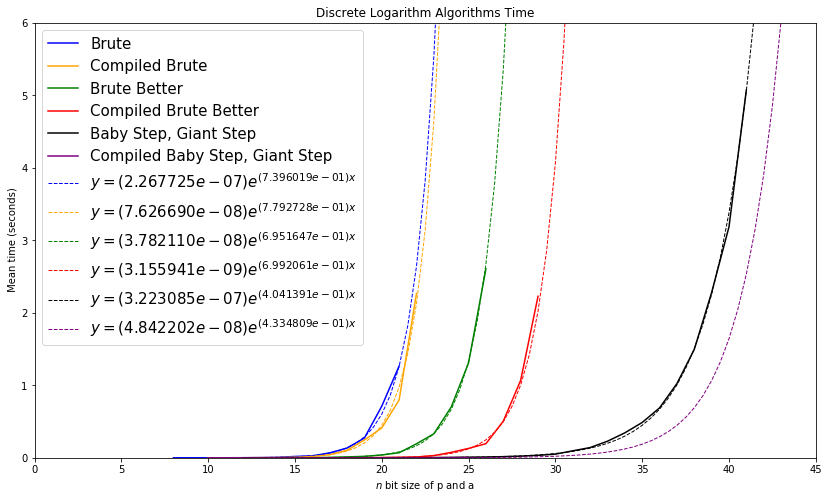

In [54]:
# Make plot
plt.figure(figsize=(14, 8))
# Plot data


# The extrapolated curves


# Plot data
# Brute
plt.plot(dl_brute_times['Mean time'], label='Brute', color='Blue')
plt.plot(dl_brute_fast_times['Mean time'],
         label='Compiled Brute', color='orange')
plt.plot(dl_brute_better_times['Mean time'],
         label='Brute Better', color='green')
plt.plot(dl_brute_better_fast_times['Mean time'],
         label='Compiled Brute Better', color='red')

# Baby/Giant Steps
plt.plot(dl_step_times['Mean time'],
         label='Baby Step, Giant Step', color='black')

plt.plot(dl_step_fast_times['Mean time'],
         label='Compiled Baby Step, Giant Step', color='purple')

# The extrapolated curves
# Brute
plt.plot(*get_prediction(dl_brute_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="blue",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_fast_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="orange",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_fast_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_better_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="green",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_better_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_better_fast_times[MT], 12, 35), linewidth=1,
         linestyle="--", color="red",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_better_fast_times[MT],
                                                          ab=True)))

# Baby/Giant Steps
plt.plot(*get_prediction(dl_step_times[MT], 12, 45), linewidth=1,
         linestyle="--", color="black",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_step_times[MT], ab=True)))

plt.plot(*get_prediction(dl_step_fast_times[MT], 12, 45), linewidth=1,
         linestyle="--", color="purple",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_step_fast_times[MT], ab=True)))

plt.ylim(0, 6)
plt.xlim(0, 45)
plt.legend(loc="upper left", prop={"size": 15})
plt.xlabel(r"$n$ bit size of p and a")
plt.ylabel(r" Mean time (seconds)")
plt.title(r"Discrete Logarithm Algorithms Time")
# plt.yscale('log')

# Save the graph as an image
plt.savefig('data/Discrete Logarithm Algorithms Time Graph')


plt.show()

As discussed earlier in the project we concluded from the NIST (National Institute of Standards and Technology) that for any security method it should take over $2$ years to crack. In this case to crack the Diffie-Hellman protocol (solving the discrete logarithm problem) should take over $2$ years, when the function takes longer than two years to solve this is the point at which the function becomes infeasible. As we don't have time to test what bit size takes over 2 years we will have to use the data gathered and extrapolate. Due to the nature of extrapolation these will be approximations.

Below is a table of the bit size of $p$ and $a$ required to exceed the time needed to solve the discrete logarithm problem using the given method.

In [55]:
h = 60*60  # seconds in hour
d = 24*h  # seconds in day
w = 7*d  # seconds in week
m = 30.42 * d  # seconds in month
y = 365.25 * d  # seconds in year
MT = 'Mean time'


time_seg = [h, 5*h, 12*h, d, w, 2*w, m, 3*m, 6*m, y, 2*y]

time_name = ['1 hour', '5 hours', '12 hours', '1 day', '1 week',
             '2 weeks', '1 month', '3 months', '6 months', '1 year', '2 years']


infeasible_brute_bit = [calc_time(time_val, *get_prediction(dl_brute_times[MT], ab=True),
                                  inverse=True) for time_val in time_seg]

infeasible_brute_fast_bit = [calc_time(time_val, *get_prediction(dl_brute_fast_times[MT], ab=True),
                                       inverse=True) for time_val in time_seg]

infeasible_brute_better_bit = [calc_time(time_val, *get_prediction(dl_brute_better_times[MT], ab=True),
                                         inverse=True) for time_val in time_seg]

infeasible_brute_better_fast_bit = [calc_time(time_val, *get_prediction(dl_brute_better_fast_times[MT], ab=True),
                                              inverse=True) for time_val in time_seg]


infeasible_step_bit = [calc_time(time_val, *get_prediction(dl_step_times[MT], ab=True),
                                 inverse=True) for time_val in time_seg]

infeasible_step_fast_bit = [calc_time(time_val, *get_prediction(dl_step_fast_times[MT], ab=True),
                                 inverse=True) for time_val in time_seg]


df_infeasible = pd.DataFrame(
    {'Time': time_name, 'Brute': infeasible_brute_bit, 'Compiled Brute': infeasible_brute_fast_bit,
     'Brute Better': infeasible_brute_better_bit, 'Compiled Brute Better': infeasible_brute_better_fast_bit,
     'Step': infeasible_step_bit, 'Compiled Step': infeasible_step_fast_bit})

df_infeasible

,Time,Brute,Compiled Brute,Brute Better,Compiled Brute Better,Step,Compiled Step
0,1 hour,31.757634,31.539298,36.364170,39.705985,57.248712,57.746494
1,5 hours,33.933721,33.604606,38.679360,42.007793,61.231098,61.459318
2,12 hours,35.117423,34.728049,39.938729,43.259883,63.397353,63.478943
3,1 day,36.054613,35.617529,40.935826,44.251217,65.112474,65.077969
4,1 week,38.685637,38.114614,43.735034,47.034245,69.927424,69.567002
5,2 weeks,39.622826,39.004093,44.732132,48.025580,71.642545,71.166028
6,1 month,40.672097,39.999948,45.848476,49.135471,73.562782,72.956287
7,3 months,42.157507,41.409740,47.428838,50.706699,76.281183,75.490684
8,6 months,43.094697,42.299220,48.425936,51.698034,77.996303,77.089710
9,1 year,44.032664,43.189437,49.423861,52.690191,79.712846,78.690062


Obviously you can't have a n-bit number where $n$ isn't an integer, so taking the ceiling (rounding up) will give the bit size of $p$ and $a$ to solve the discrete logarithm problem in over the time for the given function.

In [56]:
# Saves data fram as CSV file
df_all_times.to_csv('data/Discrete Logarithm Algorithms Time Table.csv')
df_infeasible.to_csv(
    'data/Discrete Logarithm Infeasible Bit Times.csv', index=False)

It is very clear to see that the Baby/Giant step algorithm is superior to all of the brute force methods. Therefore, even if an algorithm is written in machine code for the CPU it is quicker to use a more time efficient algorithm it is also a lot easier to code. However, the space complexity (the amount of space used up) for the Baby/Giant step algorithm is inferior to all the brute algorithms, this reason is negligible as the desktops have lots of storage space, first using CPU cache then RAM and if that overflows virtual memory.

It is worth to note in the Compiled Step algorithms current state, it can't deal with high bit numbers as overflow errors will occur.

# Referencing

KATZ, J.K. LINDELL, Y.L. $\textbf{Introduction To Modern Cryptography}$. 2nd edition. Taylor and Francis group. Dec. 2014

http://numba.pydata.org/numba-doc/latest/user/index.html 24/05/2020

https://github.com/python/cpython 24/05/2020

https://en.wikipedia.org/wiki/Baby-step_giant-step 24/05/2020
